# Localized analysis: band-pass filtering, Hilbert transform

We investigate how band-pass filtering and hilbert transform can be combined in order to extract a tidal signal from the sum of a tidal signal and a low-frequency signal.
See the [main notebook](main.ipynb) for descriptions of the signal and of the filtering and hilbert transforms.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
#import sstats.sigp as sigp
import sstats.sigp_AP as sigp
from sstats import get_cmap_colors
import seaborn as sns
#import mitequinox.sigp as sp

rad = 2*np.pi

print_figs = True

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#
cluster = PBSCluster(processes=5, cores=5,walltime='02:00:00') #processes=7, cores=7
#
w = cluster.scale(jobs=4)
#
client = Client(cluster)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [3]:
client

<Client: 'tcp://10.148.0.34:49250' processes=0 threads=0, memory=0 B>

## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [4]:
def generate_filter(band, T=10, dt=1/24, lat=None, bandwidth=None, normalized_bandwidth=None):
    """Wrapper around scipy.signal.firwing
    
    Parameters
    ----------
    band: str, float
        Frequency band (e.g. "semidiurnal", ...) or filter central frequency
    T: float
        Filter length in days
    dt: float
        Filter/time series time step
    lat: float
        Latitude (for inertial band)
    bandwidth: float
        Filter bandwidth in cpd
    dt: float
        hours
    """
    numtaps = int(T*24)    
    pass_zero = False
    #
    if band == "subdiurnal":
        pass_zero = True
        cutoff = [1.0 / 2.0]    
    elif band == "semidiurnal":
        omega = 1.9322 #  M2 24/12.4206012 = 1.9322
    elif band == "diurnal":
        omega = 1. # K1 24/23.93447213 = 1.0027
    elif band == "inertial":
        try:
            omega = coriolis(lat) * 3600 / 2.0 / np.pi
        except:
            print("latitude needs to be provided to generate_filter")
    elif isinstance(band, float):
        omega = band
    #
    if bandwidth is not None:
        cutoff = [omega - bandwidth, omega + bandwidth]
    elif normalized_bandwidth is not None:
        cutoff = [omega * (1 - normalized_bandwidth), 
                  omega * (1.0 + normalized_bandwidth),
                 ]
    elif band != "subdiurnal":
        print("bandwidth or normalized_bandwidth needs to be provided")
    #
    h = signal.firwin(
        numtaps, cutoff=cutoff, pass_zero=pass_zero, fs=1/dt, scale=True
    )
    return h

def filter_response(h, dt=1/24):
    """Returns the frequency response"""
    w, hh = signal.freqz(h, worN=8000, fs=1/dt)
    return hh, w

def get_tidal_frequencies(*args, units="cpd"):
    """
    """
    from pytide import WaveTable
    td = WaveTable()
    if units=="cpd":
        scale=86400/2/np.pi
    elif units=="cph":
        scale=3600/2/np.pi
    else:
        # cps
        scale=1/2/np.pi
    return {c: td.wave(c).freq * scale for c in args}



In [5]:
def autocorrelations(ds, V,combine=False,maxlag=None,lags=None,**kwargs):
#    V = ["high", "low"]
#    if combine:
#        ds["sum"] = ds["high"]  + ds["low"]
#        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
#        V = V + ["sum"]
    R = []
    for v in V:
        if v=='low':
            R.append((sigp
                  .correlate(ds[v].real, ds[v].real,maxlag=maxlag,lags=lags,**kwargs)
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
        else:
            R.append((sigp
                      .correlate(ds[v+"_demodulated"].real, ds[v+"_demodulated"].real,maxlag=maxlag,lags=lags,**kwargs)
                      .rename(v)
                      .to_dataset()
                      .rename({'lags': 'tau'})
                     )
                    )
    return xr.merge(R)

In [6]:
dt = 1/24 # time step in days

tidal_omega = get_tidal_frequencies("M2", "K2","S2","N2")
omega_M2,omega_S2,omega_N2,omega_K2, domega, name = tidal_omega["M2"],tidal_omega["S2"],tidal_omega["N2"],tidal_omega["K2"], .2, "semidiurnal"
omega = (omega_M2+omega_S2)/2#center frequency
Tw = 30 #filter length
dband = 0.2 # half-bandwidth

print('omega M2:%s'%omega_M2)
print('omega S2:%s'%omega_S2)
print('omega N2:%s'%omega_N2)
print('omega K2:%s'%omega_K2)
#print('omega (M2+S2)/2:%s'%(omega_M2+omega_S2)/2)

omega M2:1.9322736142672448
omega S2:2.0
omega N2:1.8959819677542018
omega K2:2.0054758185413344


In [7]:
dband = [0.1,0.2,0.3] #0.05,
h,h_hat,w = {},{},{}
for d in dband:
    h[str(d)] = generate_filter(omega, T=Tw, dt=dt, bandwidth=d, normalized_bandwidth=None)
    h_hat[str(d)], w[str(d)] = filter_response(h[str(d)], dt)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


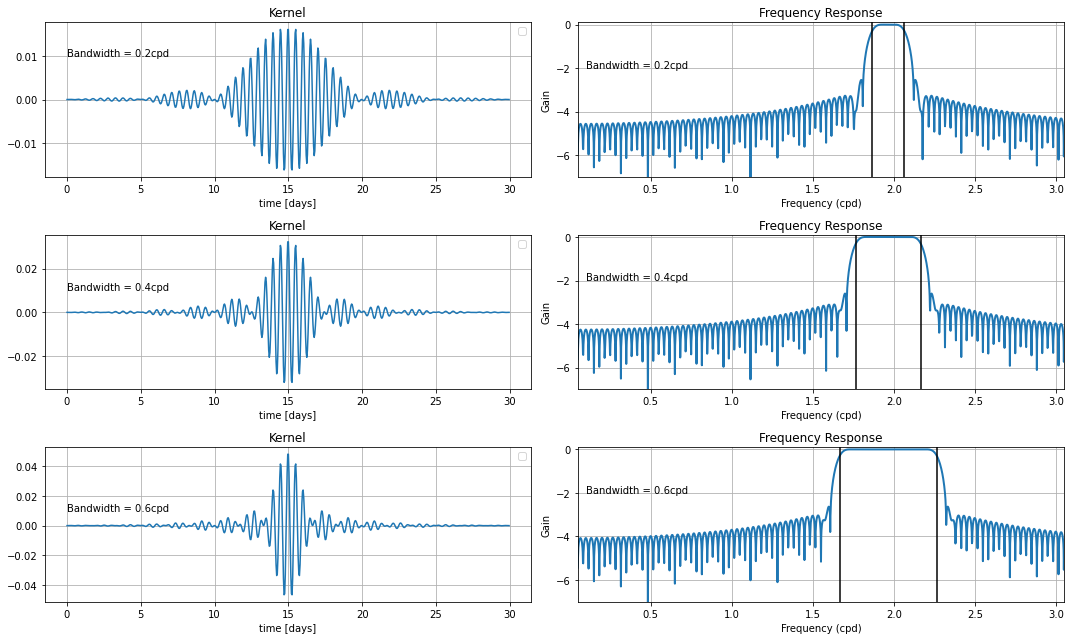

In [8]:
t = np.arange(0,30,dt)
fig, axes = plt.subplots(len(h.keys()),2, figsize=(15,3*len(h.keys())))
for i, k in enumerate(h.keys()):
    ax = axes[i,0]
    ax.plot(t, h[k])
    ax.grid()
    ax.set_xlabel('time [days]')
    ax.set_title('Kernel')
    ax.legend()
    ax.text(0,0.01,'Bandwidth = %scpd'%(2*float(k)))
    ax = axes[i,1]

    ax.plot(w[k], np.log10(abs(h_hat[k])), linewidth=2)
    ax.axvline(omega-float(k), color='k')
    ax.axvline(omega+float(k), color='k')
    ax.set_xlabel('Frequency (cpd)')
    ax.set_ylabel('Gain')
    ax.set_title('Frequency Response')
    #ax.set_ylim(-0.05, 1.05)
    ax.set_ylim(-7, 0.1)
    ax.set_xlim(0.05, 3.05)
    ax.grid(True)
    ax.text(0.1,-2,'Bandwidth = %scpd'%(2*float(k)))
    
fig.tight_layout()

In [9]:
t_size=300
T,T_low = [5,30,80],[5,15,30]
U_high = [0.1]#[0.01,0.05,0.1,1.]
nb_draws = 500

### Generation signal: 

In [10]:
def generate_timeseries(delta_T, n_draws, T, sigma0, seed, filtering = True, chunks=dict(T=-1)):
    u = mu + ts.exp_autocorr((delta_T, dt), T, 
                             np.sqrt(sigma0), 
                             burnin=int(10*T_all[-1]/dt),
                             draws=n_draws,
                             seed=seed,
                             chunks=chunks,
                            )
    ds = u.rename("u").to_dataset()
    # low-pass filter
    if filtering:
        ds["u_bar"] = sigp.filt(ds.u, filter_h)    
    return ds

In [11]:
mu=0 # true mean
sigma0 = 1. # true variance
T = 10 # days, decorrelation timescale, base case
dt = 1/24 # hours, sampling interval

# filter properties:
filter_cutoff = 0.5 # cpd
filter_size = 20 # in days
filter_size_pts = int(20/dt) # in points

print(f"Default filter cutoff frequency and window size: {filter_cutoff}cpd , {filter_size_pts} points = {filter_size} days ")

Default filter cutoff frequency and window size: 0.5cpd , 480 points = 20 days 


In [12]:
filter_h, filter_t = sigp.lowpass_filter(filter_cutoff, filter_size_pts, dt)
h_hat, w = sigp.filter_response(filter_h, dt)

In [13]:
delta_T = t_size # time series length in days
n_draws = 500 # number of draws
T_all = [0.5*T, T, 2*T]

ds_low = generate_timeseries(delta_T, n_draws, T_all, sigma0,seed=0)

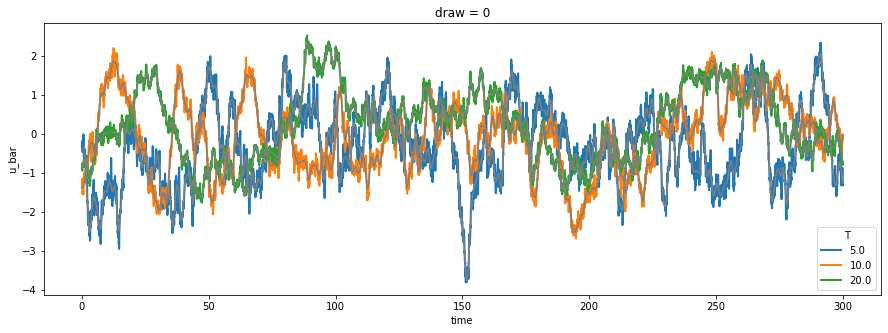

In [14]:
_ds = ds_low.sel(draw=0, T=[T_all[0], T,  T_all[-1]], method="nearest")

fig, ax = plt.subplots(1,1, figsize=(15,5))
_ds.u.plot.line(x="time", lw=2)
_ds.u_bar.plot.line(x="time", color="0.5", add_legend=False)

In [15]:
#n_draws = 500 # number of draws
i,j = 1,2
ds_hf = {}
for c,om in zip(['M2','S2'],[omega_M2,omega_S2]):
    ds_hf_real = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=i)
    ds_hf_imag = generate_timeseries(delta_T, n_draws, T_all, sigma0, filtering=False,seed=i)
    ds_hf[c] = (ds_hf_real/np.sqrt(2)*np.exp(1j*om*rad*ds_hf_real['u'].time)+1j*ds_hf_imag/np.sqrt(2)*np.exp(1j*(om*rad)*ds_hf_real['u'].time)).u
    ds_hf[c] = ds_hf[c].chunk({'time':-1,'draw':-1,'T':-1})
    i+=2
   # j+=2
ds_hf

{'M2': <xarray.DataArray 'u' (T: 3, time: 7200, draw: 500)>
 dask.array<add, shape=(3, 7200, 500), dtype=complex128, chunksize=(3, 7200, 500), chunktype=numpy.ndarray>
 Coordinates:
   * T        (T) float64 5.0 10.0 20.0
   * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
   * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499,
 'S2': <xarray.DataArray 'u' (T: 3, time: 7200, draw: 500)>
 dask.array<add, shape=(3, 7200, 500), dtype=complex128, chunksize=(3, 7200, 500), chunktype=numpy.ndarray>
 Coordinates:
   * T        (T) float64 5.0 10.0 20.0
   * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
   * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499}

In [16]:
sigma = [0.01,0.1,1.,2.]
for c,om in zip(['M2','S2'],[omega_M2,omega_S2]):
    ds_hf[c] = xr.concat([np.sqrt(u)*ds_hf[c] for u in sigma],dim='rms').assign_coords({'rms':sigma})
    ds_hf[c+'_coh'] = xr.concat([np.sqrt(u)*np.exp(1j*om*rad*ds_hf_real['u'].time
                                                  ) for u in sigma],dim='rms').assign_coords({'rms':sigma})

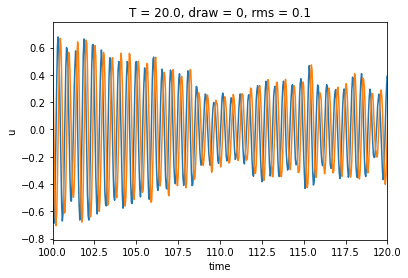

In [17]:
ds_hf['M2'].real.sel(draw=0,T=T_all[2],rms=0.1).plot(xlim=(100,120))
ds_hf['M2'].imag.sel(draw=0,T=T_all[2],rms=0.1).plot(xlim=(100,120))

In [18]:
ds_hf['high_MS'] = ds_hf['M2']+ds_hf['S2']

In [19]:
ds_hf['high_MS_coh'] = ds_hf['M2_coh']+ds_hf['S2_coh']

ds_hf['M2_mix'] = ds_hf['M2']/np.sqrt(2)+ds_hf['M2_coh']/np.sqrt(2)
ds_hf['S2_mix'] = ds_hf['S2']/np.sqrt(2)+ds_hf['S2_coh']/np.sqrt(2)
ds_hf['high_MS_mix'] = ds_hf['M2_mix']+ds_hf['S2_mix']

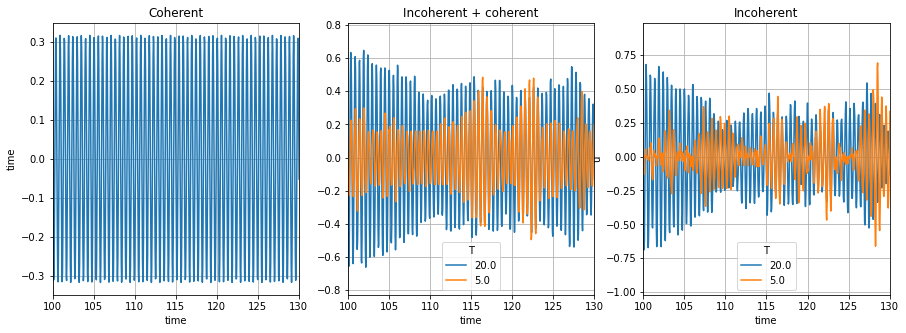

In [20]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ax=axs[0]
ds_hf['M2_coh'].real.sel(rms=0.1).plot(xlim=(100,130),ax=ax)
ax.set_title('Coherent');ax.grid()
for p, ax,title in zip(['_mix',''],axs[1:],['Incoherent + coherent','Incoherent']):
    ds_hf['M2'+p].real.sel(draw=0,rms=0.1,T=[T_all[-1],T_all[0]]).plot(xlim=(100,130),ax=ax,hue='T')
    ax.grid();ax.set_title(title)

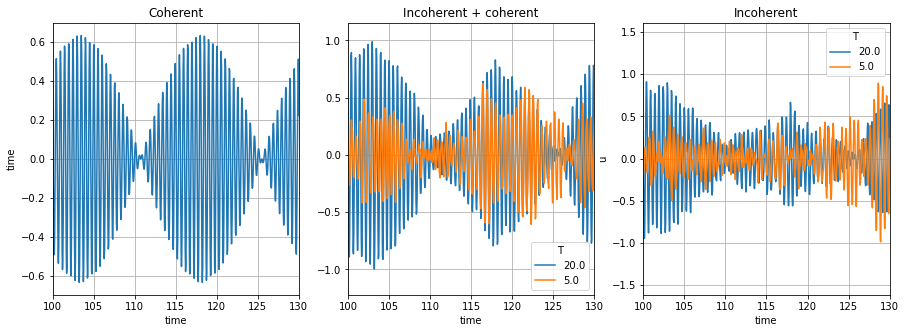

In [21]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ax=axs[0]
ds_hf['high_MS_coh'].sel(rms=0.1).real.plot(xlim=(100,130),ax=ax)
ax.set_title('Coherent');ax.grid()
for p, ax,title in zip(['_mix',''],axs[1:],['Incoherent + coherent','Incoherent']):
    ds_hf['high_MS'+p].real.sel(draw=0,rms=0.1,T=[T_all[-1],T_all[0]]).plot(xlim=(100,130),ax=ax,hue='T')
    ax.grid();ax.set_title(title)

In [22]:
exp_M2_demod = np.exp(-1j*omega_M2*rad*ds_hf['M2'].time)
exp_S2_demod = np.exp(-1j*omega_S2*rad*ds_hf['S2'].time)
exp_MS_demod = np.exp(-1j*omega*rad*ds_hf['S2'].time)

In [23]:
p = '_coh'
for c,exp in zip(['M2','S2','high_MS'],[exp_M2_demod,exp_S2_demod,exp_MS_demod]):
    ds_hf[c+p+'_analytical'] = xr.DataArray(signal.hilbert(ds_hf[c+p].real)
                                            ,coords={"rms":sigma,"time":ds_hf['M2'].time})
    #    ds_hf[c+p+'_analytical'] = ds_hf[c+p].real+
    ds_hf[c+p+'_demodulated'] = ds_hf[c+p]*exp
    ds_hf[c+p+'_demodulated_bis'] = ds_hf[c+p+'_analytical']*exp

In [24]:
#p = '_coh'
for c,exp in zip(['M2','S2','high_MS'],[exp_M2_demod,exp_S2_demod,exp_MS_demod]):
    for p in ['_mix','']:
        ds_hf[c+p+'_analytical'] = xr.DataArray(signal.hilbert(ds_hf[c+p].real),
                                                coords={"rms":sigma,"T":T_all,
                                                        "time":ds_hf['M2'].time,
                                                        "draw":ds_hf['M2'].draw})
    #    ds_hf[c+p+'_analytical'] = ds_hf[c+p].real+
        ds_hf[c+p+'_demodulated'] = ds_hf[c+p]*exp
        ds_hf[c+p+'_demodulated_bis'] = ds_hf[c+p+'_analytical']*exp

In [25]:
ds_M2 = xr.Dataset({'M2'+c :xr.concat([ds_hf['M2'+p+c].rename('M2') for p in ['_coh','_mix','']],
               dim='signal').assign_coords({'signal':['coherent','mixed','incoherent']}
                                        )  for c in ['','_demodulated','_demodulated_bis','_analytical']}).persist()
ds_S2 = xr.Dataset({'S2'+c :xr.concat([ds_hf['S2'+p+c].rename('M2') for p in ['_coh','_mix','']],
               dim='signal').assign_coords({'signal':['coherent','mixed','incoherent']}
                                        )  for c in ['','_demodulated','_demodulated_bis','_analytical']}).persist()
ds_MS = xr.Dataset({'MS'+c :xr.concat([ds_hf['high_MS'+p+c].rename('M2') for p in ['_coh','_mix','']],
               dim='signal').assign_coords({'signal':['coherent','mixed','incoherent']}
                                        )  for c in ['','_demodulated','_demodulated_bis','_analytical']}).persist()
ds_M2 = ds_M2.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})
ds_S2 = ds_S2.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})
ds_MS = ds_MS.chunk({'time':-1,'draw':-1,'T':-1,'signal':-1})

In [26]:
for p in ['','_demodulated','_demodulated_bis']:
    ds_M2['M2'+p+'_real'] = ds_M2['M2'+p].real
    ds_M2['M2'+p+'_imag'] = ds_M2['M2'+p].imag
    ds_S2['S2'+p+'_real'] = ds_S2['S2'+p].real
    ds_S2['S2'+p+'_imag'] = ds_S2['S2'+p].imag
    ds_MS['MS'+p+'_real'] = ds_MS['MS'+p].real
    ds_MS['MS'+p+'_imag'] = ds_MS['MS'+p].imag

In [27]:
ds = xr.merge([ds_M2,ds_S2,ds_MS]).persist()

In [28]:
ds

<xarray.Dataset>
Dimensions:                  (T: 3, draw: 500, time: 7200, rms: 4, signal: 3)
Coordinates:
  * T                        (T) float64 5.0 10.0 20.0
  * draw                     (draw) int64 0 1 2 3 4 5 ... 495 496 497 498 499
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
  * rms                      (rms) float64 0.01 0.1 1.0 2.0
  * signal                   (signal) <U10 'coherent' 'mixed' 'incoherent'
Data variables: (12/30)
    M2                       (signal, rms, time, T, draw) complex128 dask.array<chunksize=(3, 1, 7200, 3, 500), meta=np.ndarray>
    M2_demodulated           (signal, rms, time, T, draw) complex128 dask.array<chunksize=(3, 1, 7200, 3, 500), meta=np.ndarray>
    M2_demodulated_bis       (signal, rms, time, T, draw) complex128 dask.array<chunksize=(3, 4, 7200, 3, 500), meta=np.ndarray>
    M2_analytical            (signal, rms, time, T, draw) complex128 dask.array<chunksize=(3, 4, 7200, 3, 500), meta=np.ndarray>
    M2_real                  (signal, rms, time, T, draw) float64 dask.array<chunksize=(3, 1, 7200, 3, 500), meta=np.ndarray>
    M2_imag                  (signal, rms, time, T, draw) float64 dask.array<chunksize=(3, 1, 7200, 3, 500), meta=np.ndarray>
    ...                       ...
    MS_real                  (signal, rms, time, T, draw) float64 dask.array<chunksize=(3, 1, 7200, 3, 500), meta=np.ndarray>
    MS_imag                  (signal, rms, time, T, draw) float64 dask.array<chunksize=(3, 1, 7200, 3, 500), meta=np.ndarray>
    MS_demodulated_real      (signal, rms, time, T, draw) float64 dask.array<chunksize=(3, 1, 7200, 3, 500), meta=np.ndarray>
    MS_demodulated_imag      (signal, rms, time, T, draw) float64 dask.array<chunksize=(3, 1, 7200, 3, 500), meta=np.ndarray>
    MS_demodulated_bis_real  (signal, rms, time, T, draw) float64 dask.array<chunksize=(3, 4, 7200, 3, 500), meta=np.ndarray>
    MS_demodulated_bis_imag  (signal, rms, time, T, draw) float64 dask.array<chunksize=(3, 4, 7200, 3, 500), meta=np.ndarray>

In [29]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
for s,ax in zip(ds.signal,axs):
    (np.abs(ds.M2_demodulated.sel(signal=s,rms=0.1))**2).mean('draw').plot(ax=ax,hue='T',ylim=(0.08,0.12))
    ax.grid();ax.set_title(s.values)
#plt.figure()
#(np.abs(ds.sel(T=T_all[0]).M2_demodulated)**2).plot(hue='part',ylim=(0.08,0.12))

In [30]:
(np.abs(ds.M2_demodulated.sel(rms=0.1))**2/0.1).mean(['draw','time']).plot(x='T',hue='signal')
plt.grid();plt.title('Variance of generated signals (averaged over draws and time)')

Text(0.5, 1.0, 'Variance of generated signals (averaged over draws and time)')

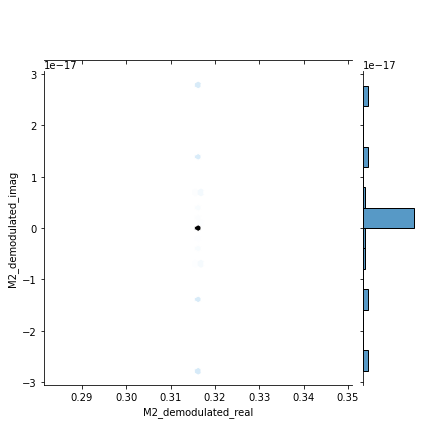

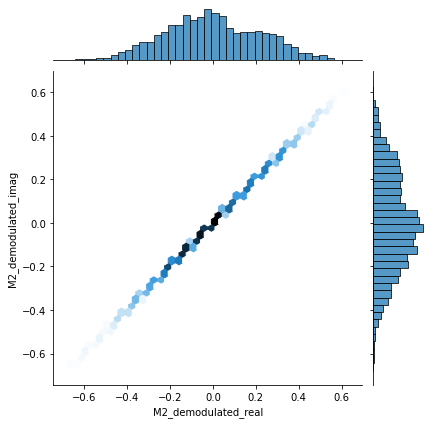

In [31]:
import seaborn as sns
sns.jointplot(data=ds.sel(draw=0,T=T_all[0],signal='coherent',rms=0.1),
              x = 'M2_demodulated_real',y = 'M2_demodulated_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[0],signal='mixed',rms=0.1),
              x = 'M2_demodulated_real',y = 'M2_demodulated_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[0],signal='incoherent',rms=0.1),
              x = 'M2_demodulated_real',y = 'M2_demodulated_imag',kind='hex')

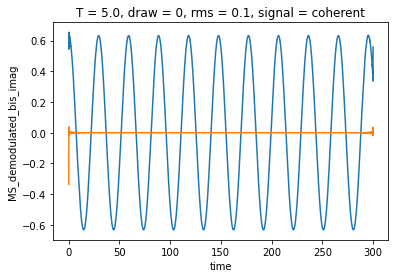

In [32]:
ds.sel(draw=0,T=T_all[0],signal='coherent',rms=0.1).MS_demodulated_bis_real.plot()
ds.sel(draw=0,T=T_all[0],signal='coherent',rms=0.1).MS_demodulated_bis_imag.plot()

In [ ]:
import seaborn as sns
sns.jointplot(data=ds.sel(draw=0,T=T_all[0],signal='coherent',rms=0.1),
              x = 'M2_demodulated_bis_real',y = 'M2_demodulated_bis_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[0],signal='mixed',rms=0.1),
              x = 'M2_demodulated_bis_real',y = 'M2_demodulated_bis_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[0],signal='incoherent',rms=0.1),
              x = 'M2_demodulated_bis_real',y = 'M2_demodulated_bis_imag',kind='hex')

KeyboardInterrupt: 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function flush_figures at 0x2aabbe11fdc0> (for post_execute):
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/IPython/core/events.py", line 89, in trigger
    func(*args, **kwargs)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/matplotlib_inline/backend_inline.py", line 121, in flush_figures
    return show(True)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/matplotlib_inline/backend_inline.py", line 41, in show
    display(
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/IPython/core/display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/IPython/core/formatters.py", line 180, in format
    data = formatter(obj)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco

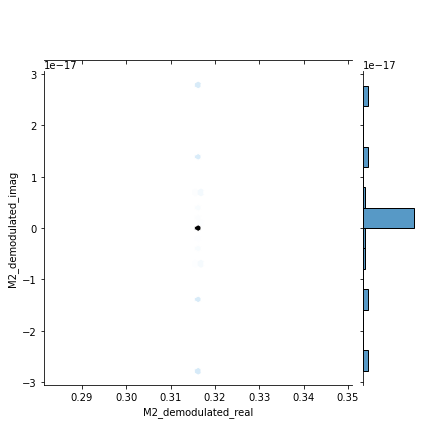

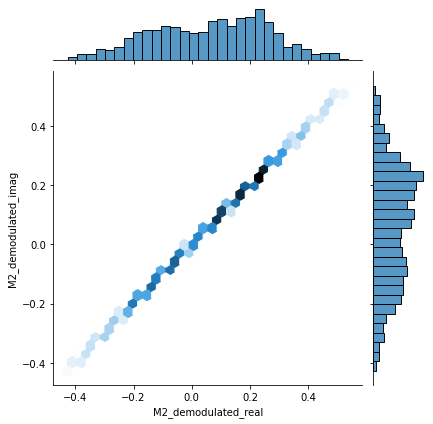

In [34]:
sns.jointplot(data=ds.sel(draw=0,T=T_all[-1],signal='coherent',rms=0.1),
              x = 'M2_demodulated_real',y = 'M2_demodulated_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[-1],signal='mixed',rms=0.1),
              x = 'M2_demodulated_real',y = 'M2_demodulated_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[-1],signal='incoherent',rms=0.1),
              x = 'M2_demodulated_real',y = 'M2_demodulated_imag',kind='hex')

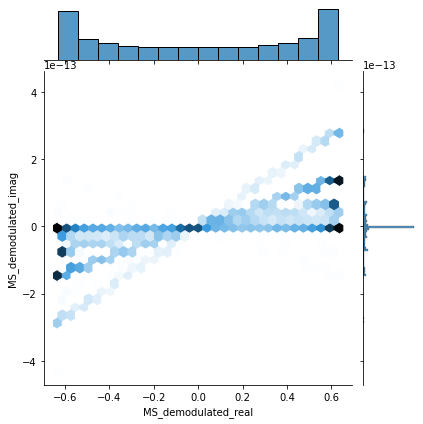

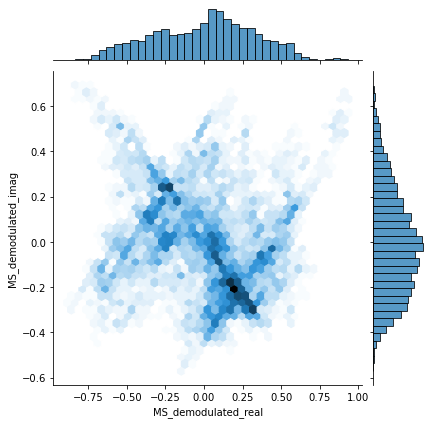

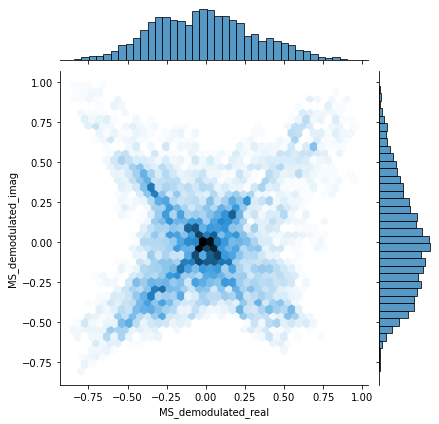

In [35]:
sns.jointplot(data=ds.sel(draw=0,T=T_all[0],signal='coherent',rms=0.1),
              x = 'MS_demodulated_real',y = 'MS_demodulated_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[0],signal='mixed',rms=0.1),
              x = 'MS_demodulated_real',y = 'MS_demodulated_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[0],signal='incoherent',rms=0.1),
              x = 'MS_demodulated_real',y = 'MS_demodulated_imag',kind='hex')

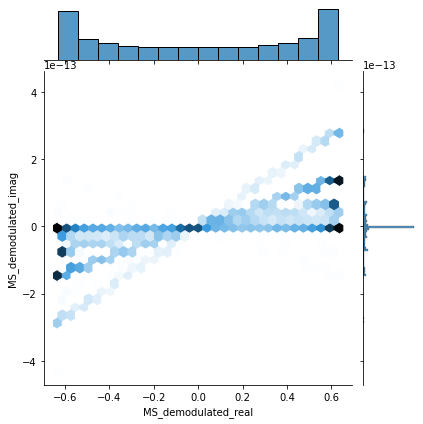

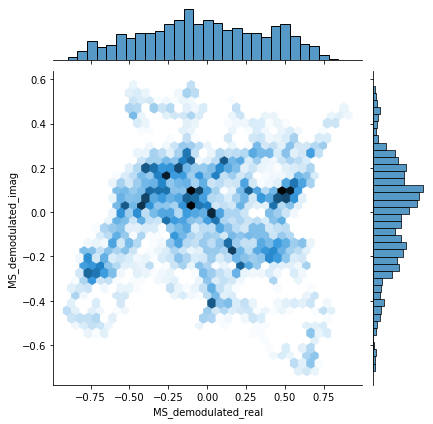

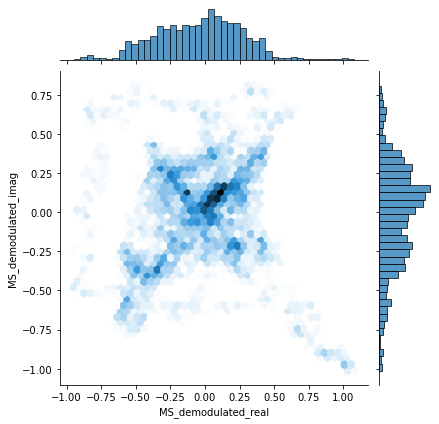

In [36]:
sns.jointplot(data=ds.sel(draw=0,T=T_all[-1],signal='coherent',rms=0.1),
              x = 'MS_demodulated_real',y = 'MS_demodulated_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[-1],signal='mixed',rms=0.1),
              x = 'MS_demodulated_real',y = 'MS_demodulated_imag',kind='hex')

sns.jointplot(data=ds.sel(draw=0,T=T_all[-1],signal='incoherent',rms=0.1),
              x = 'MS_demodulated_real',y = 'MS_demodulated_imag',kind='hex')

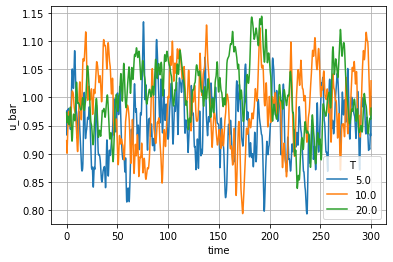

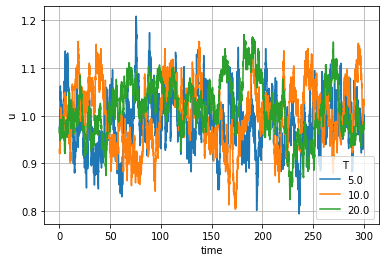

In [37]:
((ds_low.u_bar)**2).mean('draw').plot(hue='T')
plt.grid();
plt.figure()
((ds_low.u)**2).mean('draw').plot(hue='T')
plt.grid();

In [38]:
((ds_low.u_bar)**2).mean(['draw','time']).plot(x='T')
((ds_low.u)**2).mean(['draw','time']).plot(x='T')
plt.grid();

In [39]:
ds['total_M2'] = ds['M2']+ds_low.u.rename({'T':'T_low'})
ds['total_MS'] = ds['MS']+ds_low.u.rename({'T':'T_low'})

In [40]:
_ds = ds[['M2','S2','MS','total_M2','total_MS']]

In [41]:
ds_filtered_M2 = xr.concat([sigp.bpass_demodulate(xr.Dataset(data_vars = {'M2':_ds['M2']}).real,omega_M2,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]], dim= 'bandwidth'
                          ).assign_coords({'bandwidth':[0.2,0.4,0.6]}).persist()

In [42]:
ds_filtered_M2_bis = xr.concat([sigp.bpass_demodulate(xr.Dataset(data_vars = {'M2':_ds['M2']}).real,omega,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]], dim= 'bandwidth'
                          ).assign_coords({'bandwidth':[0.2,0.4,0.6]}).persist()

In [43]:
ds_filtered_MS = xr.concat([sigp.bpass_demodulate(xr.Dataset(data_vars = {'MS':_ds['MS']}).real,omega,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]], dim= 'bandwidth'
                          ).assign_coords({'bandwidth':[0.2,0.4,0.6]}).persist()

In [44]:
ds_filtered_total = xr.concat([sigp.bpass_demodulate(xr.Dataset(data_vars = {'total_MS':_ds['total_MS']}).real,omega,dband,30
                                                 )[0] for dband in [0.1,0.2,0.3]], dim= 'bandwidth'
                          ).assign_coords({'bandwidth':[0.2,0.4,0.6]}).persist()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

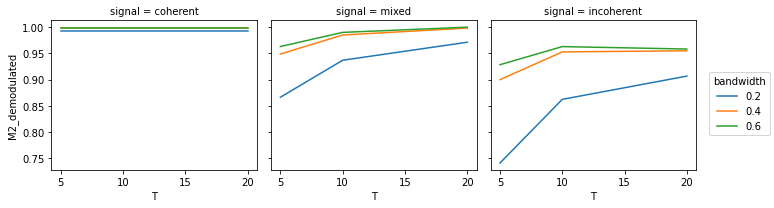

In [45]:
(np.abs(ds_filtered_M2.M2_demodulated.sel(rms=0.01))**2/0.01).mean(['draw','time']).plot(x='T',col='signal',hue='bandwidth')
#plt.grid();#plt.title('Variance of generated signals (averaged over draws and time)')

plt.figure()
(np.abs(ds_filtered_M2.M2_demodulated.sel(rms=0.1))**2/0.1).mean(['draw','time']).plot(x='T',col='signal',hue='bandwidth')

plt.figure()
(np.abs(ds_filtered_M2.M2_demodulated.sel(rms=1.))**2).mean(['draw','time']).plot(x='T',col='signal',hue='bandwidth')

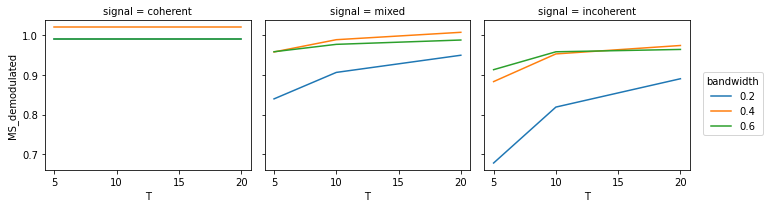

<Figure size 432x288 with 0 Axes>

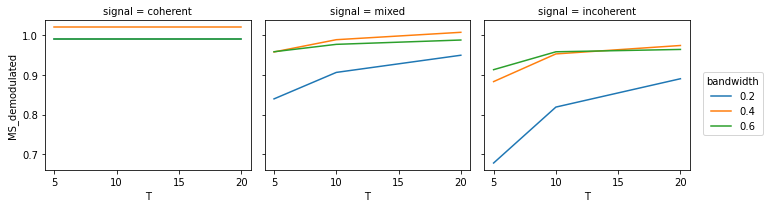

<Figure size 432x288 with 0 Axes>

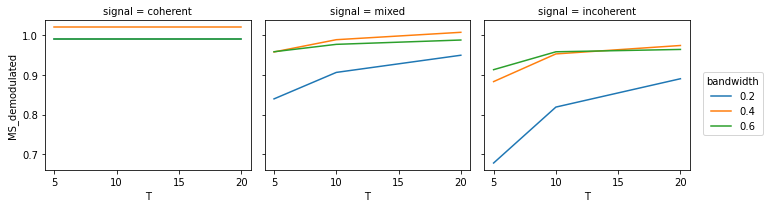

In [46]:
(np.abs(ds_filtered_MS.MS_demodulated.sel(rms=0.01))**2/0.02).mean(['draw','time']).plot(x='T',col='signal',hue='bandwidth')
#plt.grid();#plt.title('Variance of generated signals (averaged over draws and time)')

plt.figure()
(np.abs(ds_filtered_MS.MS_demodulated.sel(rms=0.1))**2/0.2).mean(['draw','time']).plot(x='T',col='signal',hue='bandwidth')

plt.figure()
(np.abs(ds_filtered_MS.MS_demodulated.sel(rms=1.))**2/2).mean(['draw','time']).plot(x='T',col='signal',hue='bandwidth')

In [47]:
(np.abs(ds_filtered_total.total_MS_demodulated.sel(rms=0.01,T_low=5))**2/0.02).mean(['draw','time']).plot(col='signal',hue='bandwidth')
#plt.grid();#plt.title('Variance of generated signals (averaged over draws and time)')

plt.figure()
(np.abs(ds_filtered_total.total_MS_demodulated.sel(rms=0.1,T_low=5))**2/0.2).mean(['draw','time']).plot(col='signal',hue='bandwidth')

plt.figure()
(np.abs(ds_filtered_total.total_MS_demodulated.sel(rms=1.,T_low=5))**2/2).mean(['draw','time']).plot(col='signal',hue='bandwidth')

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

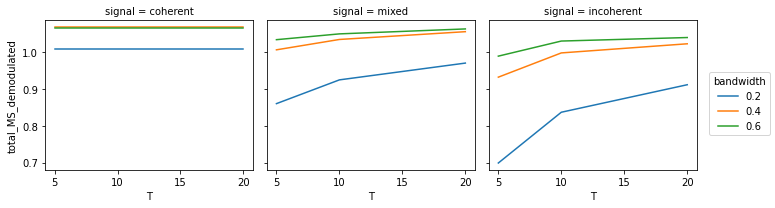

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

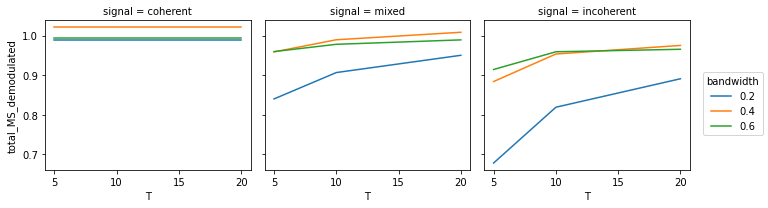

In [48]:
(np.abs(ds_filtered_total.total_MS_demodulated.sel(rms=0.01,T_low=20))**2/0.02).mean(['draw','time']).plot(col='signal',hue='bandwidth')
#plt.grid();#plt.title('Variance of generated signals (averaged over draws and time)')

plt.figure()
(np.abs(ds_filtered_total.total_MS_demodulated.sel(rms=0.1,T_low=20))**2/0.2).mean(['draw','time']).plot(col='signal',hue='bandwidth')

plt.figure()
(np.abs(ds_filtered_total.total_MS_demodulated.sel(rms=1.,T_low=20))**2/2).mean(['draw','time']).plot(col='signal',hue='bandwidth')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


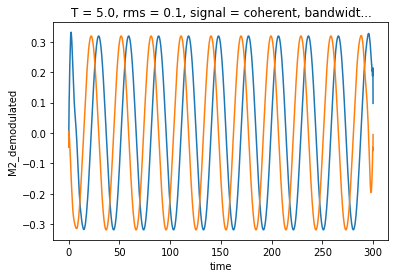

In [49]:
(ds_filtered_M2_bis.sel(signal='coherent',rms=0.1,bandwidth=0.4,T=5).mean('draw').M2_demodulated.real).plot()
(ds_filtered_M2_bis.sel(signal='coherent',rms=0.1,bandwidth=0.4,T=5).mean('draw').M2_demodulated.imag).plot()

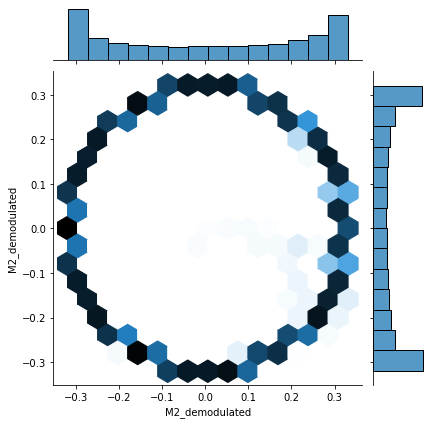

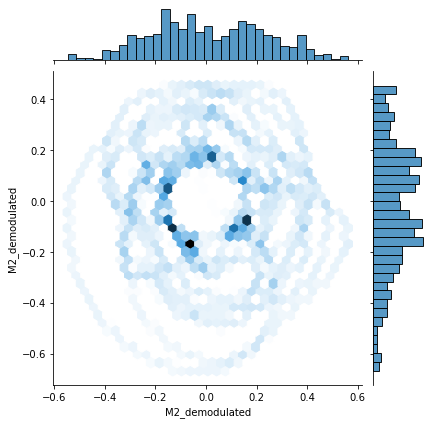

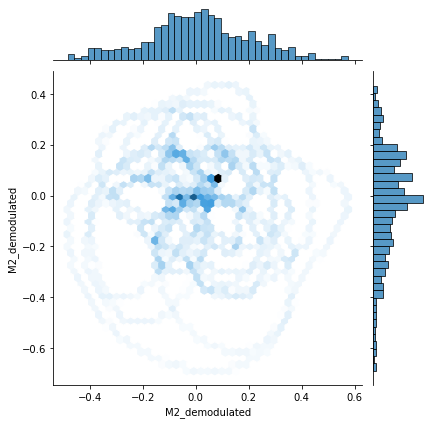

In [50]:
sns.jointplot(x = ds_filtered_M2_bis.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='coherent',rms=0.1).M2_demodulated.real
              ,y = ds_filtered_M2_bis.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='coherent',rms=0.1).M2_demodulated.imag
              ,kind='hex')

sns.jointplot(x = ds_filtered_M2_bis.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='mixed',rms=0.1).M2_demodulated.real
              ,y = ds_filtered_M2_bis.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='mixed',rms=0.1).M2_demodulated.imag
              ,kind='hex')

sns.jointplot(x = ds_filtered_M2_bis.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='incoherent',rms=0.1).M2_demodulated.real
              ,y = ds_filtered_M2_bis.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='incoherent',rms=0.1).M2_demodulated.imag
              ,kind='hex')

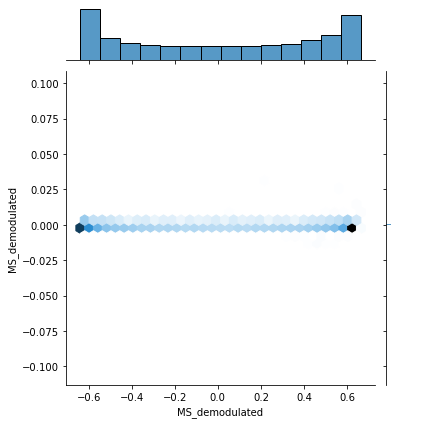

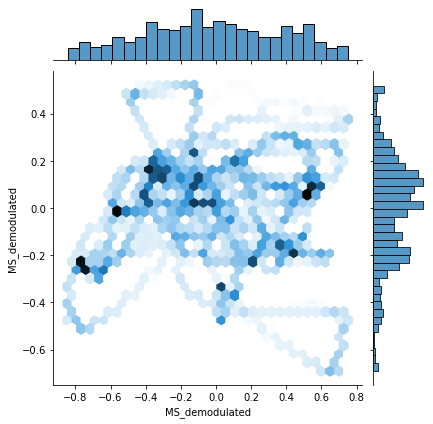

In [51]:
sns.jointplot(x = ds_filtered_MS.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='coherent',rms=0.1).MS_demodulated.real
              ,y = ds_filtered_MS.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='coherent',rms=0.1).MS_demodulated.imag
              ,kind='hex')

sns.jointplot(x = ds_filtered_MS.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='mixed',rms=0.1).MS_demodulated.real
              ,y = ds_filtered_MS.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='mixed',rms=0.1).MS_demodulated.imag
              ,kind='hex')

sns.jointplot(x = ds_filtered_MS.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='incoherent',rms=0.1).MS_demodulated.real
              ,y = ds_filtered_MS.sel(draw=0,T=T_all[-1],bandwidth=0.4,signal='incoherent',rms=0.1).MS_demodulated.imag
              ,kind='hex')

In [52]:
ds_mean = xr.merge([ds_filtered_M2.drop('exp'),ds_filtered_MS.drop('exp'),ds_filtered_total.drop('exp')])

In [ ]:
ds_mean = ds_mean[

In [69]:
ds_mean.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_IT_mean.nc')

TypeError: illegal primitive data type, must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got complex128

In [53]:
def autocorrelations(ds, V,combine=False,maxlag=None,lags=None,**kwargs):
#    V = ["high", "low"]
#    if combine:
#        ds["sum"] = ds["high"]  + ds["low"]
#        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
#        V = V + ["sum"]
    R = []
    for v in V:
        if v=='low':
            R.append((sigp
                  .correlate(ds[v].real, ds[v].real,maxlag=maxlag,lags=lags,**kwargs)
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
        else:
            R.append((sigp
                      .correlate(ds[v+"_demodulated_real"], ds[v+"_demodulated_real"],**kwargs) #,maxlag=maxlag,lags=lags,**kwargs
                      .rename(v)
                      .to_dataset()
                      .rename({'lags': 'tau'})
                     )
                    )
    return xr.merge(R)

In [54]:
## Autocorrelation : 
R_stat = {}
maxlag = t_size
lags = np.arange(0,maxlag//2,1/24)
for k in ['M2','MS']:
#    R_stat[k] = autocorrelations(ds,[k],maxlag=maxlag,lags = lags,**{'mode':'valid'})
    R_stat[k] = autocorrelations(ds,[k],biased=False) #,maxlag=maxlag,lags = lags,**{'mode':'valid'}

/home1/datahome/zcaspar/synthetic_stats/sstats/sigp_AP.py:176: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,
/home1/datahome/zcaspar/synthetic_stats/sstats/sigp_AP.py:176: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,


In [55]:
R_stat['M2'].sel(tau=slice(0,100)).sel(draw=0,rms=0.1).M2.plot(hue='T',col='signal')

plt.figure()
R_stat['MS'].sel(tau=slice(0,100)).sel(draw=0,rms=0.1).MS.plot(hue='T',col='signal')

<Figure size 432x288 with 0 Axes>

In [56]:
R_stat['M2'].sel(tau=slice(0,100)).sel(rms=0.1).M2.mean('draw').plot(hue='T',col='signal')

plt.figure()
R_stat['MS'].sel(tau=slice(0,100)).sel(rms=0.1).MS.mean('draw').plot(hue='T',col='signal')

<Figure size 432x288 with 0 Axes>

In [58]:

def autocorrelations(ds, V,combine=False,maxlag=None,lags=None,**kwargs):
#    V = ["high", "low"]
#    if combine:
#        ds["sum"] = ds["high"]  + ds["low"]
#        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
#        V = V + ["sum"]
    R = []
    for v in V:
        if v=='low':
            R.append((sigp
                  .correlate(ds[v].real, ds[v].real,maxlag=maxlag,lags=lags,**kwargs)
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
        else:
            R.append((sigp
                      .correlate(ds[v+"_demodulated"].real, ds[v+"_demodulated"].real,**kwargs) #,maxlag=maxlag,lags=lags,**kwargs
                      .rename(v)
                      .to_dataset()
                      .rename({'lags': 'tau'})
                     )
                    )
    return xr.merge(R)

In [59]:
## Autocorrelation : 
R_stat_filt = {}
maxlag = t_size
lags = np.arange(0,maxlag//2,1/24)
for k in ['total_MS']:
#    R_stat[k] = autocorrelations(ds,[k],maxlag=maxlag,lags = lags,**{'mode':'valid'})
    R_stat_filt[k] = autocorrelations(ds_filtered_total,[k],biased=False).persist() #,maxlag=maxlag,lags = lags,**{'mode':'valid'}

/home1/datahome/zcaspar/synthetic_stats/sstats/sigp_AP.py:176: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(_correlate, v1, v2,


In [60]:
#R_stat['M2'].sel(tau=slice(0,100)).sel(rms=0.1).M2.mean('draw').plot(hue='T',col='signal')

#plt.figure()
R_stat_filt['total_MS'].sel(tau=slice(0,100)).sel(bandwidth=0.2,T_low=20
                                            ).total_MS.mean('draw').plot(hue='T',col='signal',row='rms',sharey=False)

#plt.figure()
#R_stat['total_MS'].sel(tau=slice(0,100)).sel(rms=0.1,bandwidth=0.4,T_low=20).total_MS.mean('draw').plot(hue='T',col='signal')

#### Variogram

In [68]:
from sstats import models
mu=0 # true mean
sigma0 = 0.1 # true variance
T = 10 # days, decorrelation timescale

delta_T = 100 # time series length
#delta_T = 300 # time series length
dt = 1/24 # sampling interval in days
Nw0 = 10 # number of windows averaged in the nominal case
Nw = [2, 5, 10, 20, 40]


# generate time series
u = mu + ts.exp_autocorr((delta_T, dt), T, 
                         np.sqrt(sigma0), 
                         #burnin=int(10*T/dt),
                         draws=1000, 
                         seed=0,
                        ).compute()

## derived parameters:
sigma_true = lambda tau: models["exp"]["sigma"](tau, sigma0, T)
gamma_true = lambda tau: models["exp"]["gamma"](tau, sigma0, T)

# total number of points
N = u.time.size # = delta_T/dt 

# get effective DOF
mean_Ne, sigma0_Ne, sigma0_scale = sigp.effective_DOF(sigma_true, dt, N)

In [71]:
ds_low.u

<xarray.DataArray 'u' (T: 3, time: 7200, draw: 500)>
dask.array<add, shape=(3, 7200, 500), dtype=float64, chunksize=(3, 7200, 500), chunktype=numpy.ndarray>
Coordinates:
  * T        (T) float64 5.0 10.0 20.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499

In [77]:
sigma0 = 1.
T = T_all[0]
dt = 1/24
sigma_true = lambda tau: models["exp"]["sigma"](tau, sigma0, T)
gamma_true = lambda tau: models["exp"]["gamma"](tau, sigma0, T)

# total number of points
N = ds_low.time.size # = delta_T/dt 

# get effective DOF
mean_Ne, sigma0_Ne, sigma0_scale = sigp.effective_DOF(sigma_true, dt, N)

In [78]:
ds_low_var = sigp.svariance(ds_low.u.sel(T=T_all[0]).compute(), "time").rename("gamma_hat").to_dataset()
ds_low_var["gamma"] = ("lags", gamma_true(ds_low_var.lags.values))

In [89]:
ds_hf['M2'].sel(T=T_all[0],rms=1).compute()

<xarray.DataArray 'u' (time: 7200, draw: 500)>
array([[-0.45726598-0.45726598j,  0.34520477+0.34520477j,
        -0.34367853-0.34367853j, ..., -1.57164054-1.57164054j,
        -1.68680963-1.68680963j, -0.29764225-0.29764225j],
       [-0.15091975-0.52576916j,  0.12201631+0.4250763j ,
        -0.18472463-0.64353745j, ..., -0.56140974-1.95582038j,
        -0.57905792-2.0173025j , -0.10662763-0.37146577j],
       [ 0.08867676-0.38507596j, -0.15054004+0.65371523j,
         0.15629819-0.6787198j , ...,  0.49170237-2.13520152j,
         0.51946873-2.25577605j,  0.08787375-0.38158892j],
       ...,
       [ 0.55506108+0.24247748j,  1.43227841+0.62568836j,
         0.89958509+0.3929822j , ...,  0.4974251 +0.2172993j ,
        -0.19471617-0.08506142j, -0.9622553 -0.42035957j],
       [ 0.19711536+0.25764963j,  0.74984398+0.9801216j ,
         0.73242323+0.95735092j, ...,  0.26855982+0.35103474j,
        -0.34100344-0.44572583j, -0.73012055-0.95434109j],
       [ 0.03917786+0.26423438j,  0.17020802+1.14796506j,
         0.16610267+1.12027662j, ...,  0.09796875+0.66074853j,
        -0.0631982 -0.42623918j, -0.1627495 -1.09766123j]])
Coordinates:
    T        float64 5.0
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 299.9 299.9 300.0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
    rms      float64 1.0

In [88]:
sigp.svariance(ds_hf['M2'].sel(T=T_all[0],rms=1).compute(), "time").rename("gamma_hat").to_dataset()

TypeError: ufunc '_svariance_np_gufunc' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [86]:
ds_M2_var = sigp.svariance(ds_hf['M2'].u.sel(T=T_all[0],rms=1).compute(), "time").rename("gamma_hat").to_dataset()
ds_M2_var["gamma"] = ("lags", gamma_true(ds_M2_var.lags.values))

SyntaxError: invalid syntax (1496905194.py, line 1)

In [ ]:
ds_M2_var = sigp.svariance(ds_hf['M2'].sel(T=T_all[0],rms=1).compute(), "time").rename("gamma_hat").to_dataset()
ds_M2_var["gamma"] = ("lags", gamma_true(ds_M2_var.lags.values))

In [90]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
ERROR:asyncio:_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.57 GiB -- Worker memory limit: 2.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.57 GiB -- Worker memory limit: 2.00 GiB
distributed.worker - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 1.63 GiB -- Worker memory limit: 2.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.63 GiB -- Worker memory limit: 2.00 GiB
distr

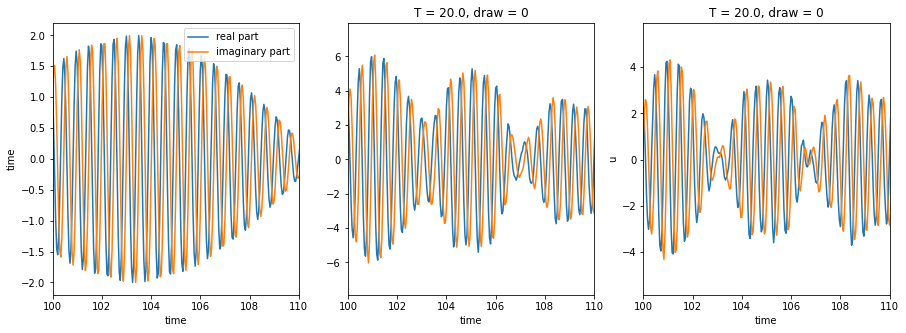

In [22]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ds_hf['M2_coh'].real.plot(ax=axs[0],xlim=(100,110),label='real part')
ds_hf['M2_coh'].imag.plot(ax=axs[0],xlim=(100,110),label='imaginary part')
#(np.abs(ds_hf['M2_coh'])**2).plot(ax=axs[0],xlim=(100,110),label='envelope')
axs[0].legend()

ds_hf['M2'].u.real.sel(T=T_all[2],draw=0).plot(ax=axs[2],xlim=(100,110),label='real part')
ds_hf['M2'].u.imag.sel(T=T_all[2],draw=0).plot(ax=axs[2],xlim=(100,110),label='imaginary part')
#(np.abs(ds_hf['M2'].u)**2).sel(T=T_all[2],draw=0).plot(ax=axs[2],xlim=(100,110),label='envelope')
axs[0].legend()

ds_hf['M2_mix'].real.sel(T=T_all[2],draw=0).plot(ax=axs[1],xlim=(100,110),label='real part')
ds_hf['M2_mix'].imag.sel(T=T_all[2],draw=0).plot(ax=axs[1],xlim=(100,110),label='imaginary part')
#(np.abs(ds_hf['M2_mix'])**2).sel(T=T_all[2],draw=0).plot(ax=axs[1],xlim=(100,110),label='envelope')
axs[0].legend()


fig,axs = plt.subplots(1,3,figsize=(15,5))
ds_hf['high_MS_coh'].real.plot(ax=axs[0],xlim=(100,110),label='real part')
ds_hf['high_MS_coh'].imag.plot(ax=axs[0],xlim=(100,110),label='imaginary part')
#(np.abs(ds_hf['high_MS_coh'])**2).plot(ax=axs[0],xlim=(100,110),label='envelope')
axs[0].legend()

ds_hf['high_MS'].u.real.sel(T=T_all[2],draw=0).plot(ax=axs[2],xlim=(100,110),label='real part')
ds_hf['high_MS'].u.imag.sel(T=T_all[2],draw=0).plot(ax=axs[2],xlim=(100,110),label='imaginary part')
#(np.abs(ds_hf['high_MS'].u)**2).sel(T=T_all[2],draw=0).plot(ax=axs[2],xlim=(100,110),label='envelope')
axs[0].legend()

ds_hf['high_MS_mix'].real.sel(T=T_all[2],draw=0).plot(ax=axs[1],xlim=(100,110),label='real part')
ds_hf['high_MS_mix'].imag.sel(T=T_all[2],draw=0).plot(ax=axs[1],xlim=(100,110),label='imaginary part')
#(np.abs(ds_hf['high_MS_mix'])**2).sel(T=T_all[2],draw=0).plot(ax=axs[1],xlim=(100,110),label='envelope')
axs[0].legend()

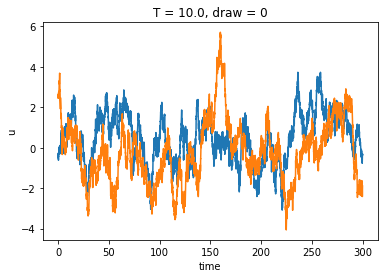

In [61]:
(ds_hf['S2_envelope']+ds_hf['M2_envelope']).sel(draw=0,T=10).u.real.plot()
(ds_hf['S2_envelope']+ds_hf['M2_envelope']).sel(draw=0,T=10).u.imag.plot()

distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.45 GiB -- Worker memory limit: 2.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.45 GiB -- Worker memory limit: 2.00 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 1.49 GiB -- Worker memory limit: 2.00 GiB


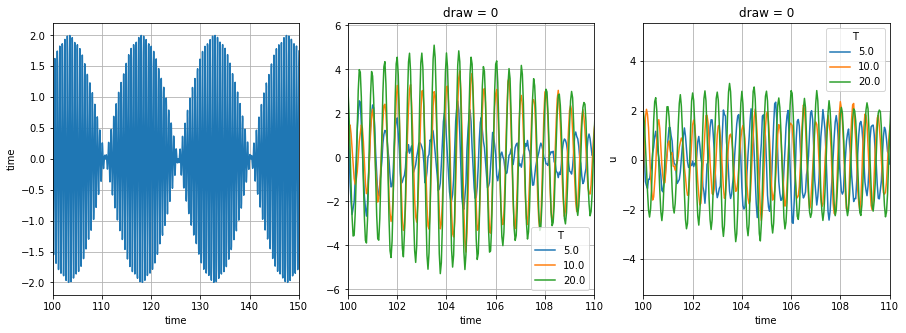

In [62]:
fig,axs = plt.subplots(1,3,figsize=(15,5))
ds_hf['M2_coh'].real.plot(ax=axs[0],xlim=(100,110),hue='T')
ds_hf['M2'].u.real.sel(draw=0).plot(ax=axs[2],xlim=(100,110),hue='T')
ds_hf['M2_mix'].real.sel(draw=0).plot(ax=axs[1],xlim=(100,110),hue='T')
for ax in axs:
    ax.grid()

fig,axs = plt.subplots(1,3,figsize=(15,5))
ds_hf['high_MS_coh'].real.plot(ax=axs[0],xlim=(100,150),label='real part')
ds_hf['high_MS'].u.real.sel(draw=0).plot(ax=axs[2],xlim=(100,110),hue='T')
ds_hf['high_MS_mix'].real.sel(draw=0).plot(ax=axs[1],xlim=(100,110),hue='T')
for ax in axs:
    ax.grid()

In [63]:
exp_M2_demod = np.exp(-1j*omega_M2*rad*ds_hf['M2'].time)
exp_S2_demod = np.exp(-1j*omega_S2*rad*ds_hf['S2'].time)
exp_MS_demod = np.exp(-1j*omega*rad*ds_hf['S2'].time)

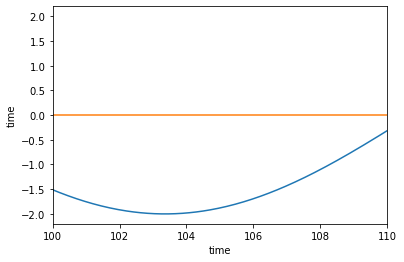

In [64]:
(ds_hf['high_MS_coh']*np.exp(-1j*omega*rad*ds_hf['S2'].time)).real.plot(xlim=(100,110))
(ds_hf['high_MS_coh']*np.exp(-1j*omega*rad*ds_hf['S2'].time)).imag.plot(xlim=(100,110))

In [65]:
z1 = ds_hf['high_MS_coh']
z2 = np.exp(-1j*omega*rad*ds_hf['S2'].time)

In [66]:
z1[100].imag*z2[100].imag

<xarray.DataArray 'time' ()>
array(-1.10485911)
Coordinates:
    time     float64 4.167

In [163]:
import cmath

In [170]:
cmath.rect(cmath.polar((z1*z2)[100]))

TypeError: rect expected 2 arguments, got 1

In [38]:
for c,exp in zip(['M2','S2','high_MS'],[exp_M2_demod,exp_S2_demod,exp_MS_demod]):
    ds_hf[c+'_coh_demodulated'] = ds_hf[c+'_coh']*exp

In [67]:
ds_hf['test'] = ds_hf['M2_coh']*exp_MS_demod

ds_hf['test1'] = ds_hf['high_MS_coh']*exp_MS_demod

In [68]:
exp_M2_demod.real.plot(xlim=(100,110))
exp_M2_demod.imag.plot(xlim=(100,110))

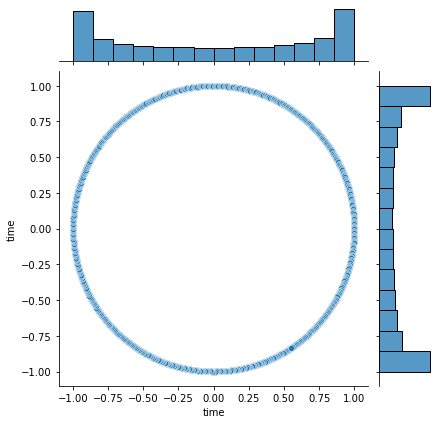

In [71]:
import seaborn as sns
sns.jointplot(x=ds_hf['test'].real,y=ds_hf['test'].imag,kind='scatter')

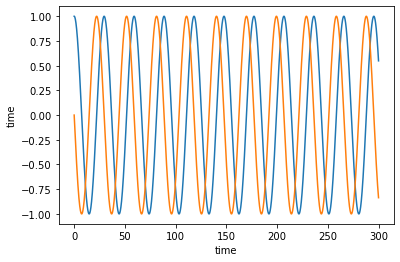

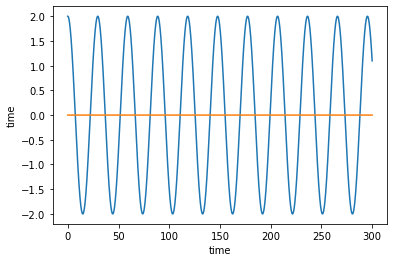

In [72]:
ds_hf['test'].real.plot()
ds_hf['test'].imag.plot()

plt.figure()
ds_hf['test1'].real.plot()
ds_hf['test1'].imag.plot()

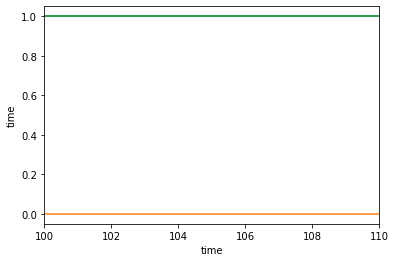

In [42]:
ds_hf['M2_coh_demodulated'].real.plot(xlim=(100,110))
ds_hf['M2_coh_demodulated'].imag.plot(xlim=(100,110))
(np.abs(ds_hf['M2_coh_demodulated'])**2).plot(xlim=(100,110))
plt.figure()
ds_hf['high_MS_coh_demodulated'].real.plot(xlim=(100,150))
ds_hf['high_MS_coh_demodulated'].imag.plot(xlim=(100,150))
(np.abs(ds_hf['high_MS_coh_demodulated'])**2).plot(xlim=(100,150))

In [43]:
exp_M2 = np.exp(1j*omega_M2*rad*u['M2'].time)
exp_S2 = np.exp(1j*omega_S2*rad*u['M2'].time)

NameError: name 'u' is not defined

In [45]:
n_draws = 500 # number of draws
ds = generate_timeseries(delta_T, n_draws, T_all)

E = xr.merge( [(ds.u**2).mean("time"), (ds.u_bar**2).mean("time")]).compute()

TypeError: generate_timeseries() missing 1 required positional argument: 'seed'

NameError: name 'E' is not defined

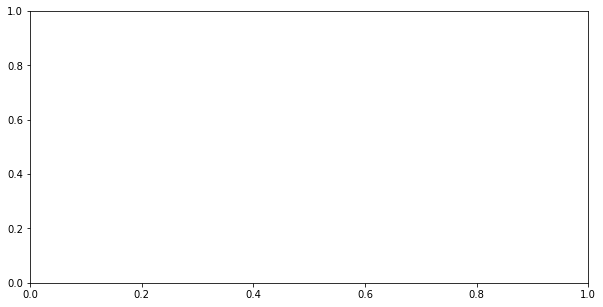

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

bins = np.arange(0,3,.1)
for _T, i in zip(ds.T[::-1],range(len(ds.T))):
    _da = E["u_bar"].sel(T=_T)
    _da.plot.hist(bins=bins, alpha=0.6, label=f"T={float(_T)}")
    ax.axvline(_da.mean(), color=f"C{i}")
ax.legend()

In [10]:
# Incoherent part

U = 0.1 # true variance

# generate time series
u = {}
i = 0
for c in ['M2','S2']:
    for part in ['real','imag']:
        i += 1
        u[c+'_'+part] = ts.exp_autocorr((t_size, dt), T, 
                                 U/np.sqrt(2), 
                                 #burnin=int(10*T/dt),
                                 draws=nb_draws, chunks={'draws':-1,'T':-1},
                                 seed=i,name=c+'_'+part+'_inc'
                                ).persist()


In [11]:
u['M2'] = u['M2_real']+1j*u['M2_imag']
u['S2'] = u['S2_real']+1j*u['S2_imag']

In [12]:
exp_M2 = np.exp(1j*omega_M2*rad*u['M2'].time)
exp_S2 = np.exp(1j*omega_S2*rad*u['M2'].time)

In [13]:
u_M2_inc = u['M2']*exp_M2
u_M2_coh = U*exp_M2
u_M2_mix = u_M2_inc/np.sqrt(2)+u_M2_coh/np.sqrt(2)

u_S2_inc = u['S2']*exp_S2
u_S2_coh = U*exp_S2
u_S2_mix = u_S2_inc/np.sqrt(2)+u_S2_coh/np.sqrt(2)

In [14]:
high_MS_mix = u_M2_mix+u_S2_mix
high_MS_coh = u_M2_coh+u_S2_coh

high_MS_inc = u_M2_inc+u_S2_inc

In [15]:
ds = xr.Dataset({'M2_coh':u_M2_coh,'S2_coh':u_S2_coh,'high_MS_coh':high_MS_coh.rename('u_high'),
                'M2_mix':u_M2_mix,'S2_mix':u_S2_mix,'high_MS_mix':high_MS_mix.rename('u_high'),
                'M2_inc':u_M2_inc,'S2_inc':u_S2_inc,'high_MS_inc':high_MS_inc.rename('u_high')
                })
ds = ds.persist()

In [16]:
for c,om in zip(['M2','S2','high_MS'],[omega_M2,omega_S2,omega]):
    
    for p in ['coh','mix','inc']:
        exp = np.exp(-1j*om*rad*ds[c+'_'+p].time)
        if p=='coh':
#            ds[c+'_'+p+'_complex'] = xr.DataArray(signal.hilbert(ds[c+'_'+p].real,axis=0),dims=["time"])
            ds[c+'_'+p+'_demodulated'] = ds[c+'_'+p]*exp
        else:
#            ds[c+'_'+p+'_complex'] = xr.DataArray(signal.hilbert(ds[c+'_'+p].real,axis=0),dims=["time","draw"])
            ds[c+'_'+p+'_demodulated'] = ds[c+'_'+p]*exp
ds = ds.persist()
ds

<xarray.Dataset>
Dimensions:                  (time: 7200, T: 3, draw: 500)
Coordinates:
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
  * T                        (T) int64 5 30 80
  * draw                     (draw) int64 0 1 2 3 4 5 ... 495 496 497 498 499
Data variables: (12/18)
    M2_coh                   (time) complex128 (0.1+0j) ... (-0.0803168680159...
    S2_coh                   (time) complex128 (0.1+0j) ... (0.08660254037841...
    high_MS_coh              (time) complex128 (0.2+0j) ... (0.00628567236244...
    M2_mix                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_mix                   (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_mix              (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    ...                       ...
    S2_coh_demodulated       (time) complex128 (0.1+0j) ... (0.1+6.9388939039...
    S2_mix_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    S2_inc_demodulated       (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_coh_demodulated  (time) complex128 (0.2+0j) ... (0.10975530623988...
    high_MS_mix_demodulated  (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>
    high_MS_inc_demodulated  (T, time, draw) complex128 dask.array<chunksize=(3, 7200, 500), meta=np.ndarray>

In [17]:
ds_mean = ds.mean('draw').persist()

In [18]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

ds.M2_inc.real.sel(draw=0,T=5).plot(ax=axs[0],xlim=(100,150),c='k',label='Incoherent signal')
ds.M2_inc_demodulated.real.sel(draw=0,T=5
                              ).plot(ax=axs[0],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.M2_coh.real.plot(ax=axs[0],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[0].legend()

ds.M2_inc.real.sel(draw=0,T=30).plot(ax=axs[1],xlim=(100,150),c='k',label='Incoherent signal')
ds.M2_inc_demodulated.real.sel(draw=0,T=30
                              ).plot(ax=axs[1],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.M2_coh.real.plot(ax=axs[1],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[1].legend()

ds.M2_inc.real.sel(draw=0,T=80).plot(ax=axs[2],xlim=(100,150),c='k',label='Incoherent signal')
ds.M2_inc_demodulated.real.sel(draw=0,T=80
                              ).plot(ax=axs[2],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.M2_coh.real.plot(ax=axs[2],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[2].legend()


In [19]:
fig,axs = plt.subplots(1,3,figsize=(15,5))

ds.high_MS_inc.real.sel(draw=0,T=5).plot(ax=axs[0],xlim=(100,150),c='k',label='Incoherent signal')
ds.high_MS_inc_demodulated.real.sel(draw=0,T=5
                              ).plot(ax=axs[0],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.high_MS_coh.real.plot(ax=axs[0],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[0].legend()

ds.high_MS_inc.real.sel(draw=0,T=30).plot(ax=axs[1],xlim=(100,150),c='k',label='Incoherent signal')
ds.high_MS_inc_demodulated.real.sel(draw=0,T=30
                              ).plot(ax=axs[1],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.high_MS_coh.real.plot(ax=axs[1],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[1].legend()

ds.high_MS_inc.real.sel(draw=0,T=80).plot(ax=axs[2],xlim=(100,150),c='k',label='Incoherent signal')
ds.high_MS_inc_demodulated.real.sel(draw=0,T=80
                              ).plot(ax=axs[2],xlim=(100,150),c='r',label='Incoherent signal amplitude')
ds.high_MS_coh.real.plot(ax=axs[2],xlim=(100,150),zorder=-1,c='grey', label = 'Coherent signal')
axs[2].legend()

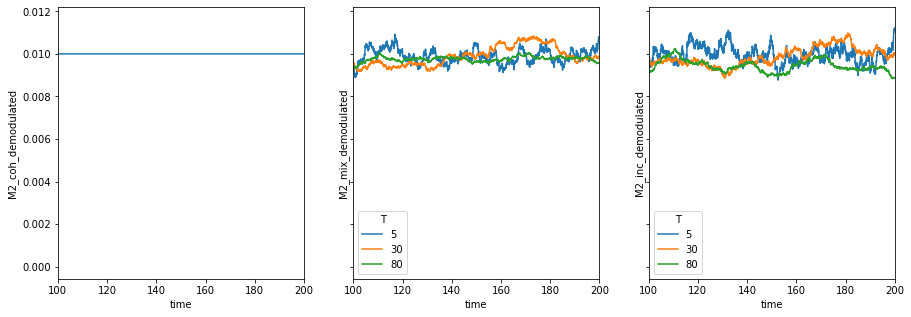

In [20]:
delta_T = 200
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
c = 'M2_coh'
#ds[c+'_demodulated'].real.plot(ax=axs[0],xlim=(0,delta_T))
#ds[c+'_demodulated'].imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds[c+'_demodulated'])**2).plot(ax=axs[0],xlim=(100,delta_T))
    
for ax,c in zip(axs[1:],['M2_mix','M2_inc']):
#    ds[c+'_demodulated'].mean('draw').real.plot(ax=ax,xlim=(0,delta_T),hue='T')
#    ds[c+'_demodulated'].imag.mean('draw').sel(T=80).plot(ax=ax,xlim=(0,delta_T))
    (np.abs(ds[c+'_demodulated'])**2).mean('draw').plot(ax=ax,xlim=(100,delta_T),hue='T') #,hue='T'

In [21]:
delta_T = 200
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
c = 'S2_coh'
(np.abs(ds[c+'_demodulated'])**2).plot(ax=axs[0],xlim=(100,delta_T))
    
for ax,c in zip(axs[1:],['S2_mix','S2_inc']):
    (np.abs(ds[c+'_demodulated'])**2).mean('draw').plot(ax=ax,xlim=(100,delta_T),hue='T') #,hue='T'

In [22]:
delta_T = 200
fig,axes = plt.subplots(1,3,figsize=(15,5),sharey=True)
axs = axes[:]
c = 'high_MS_coh'
#ds[c+'_demodulated'].real.plot(ax=axs[0],xlim=(0,delta_T))
#ds[c+'_demodulated'].imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds[c+'_demodulated'])**2).plot(ax=axs[0],xlim=(100,delta_T))
axs[0].grid()
for ax,c in zip(axs[1:],['high_MS_mix','high_MS_inc']):

    (np.abs(ds[c+'_demodulated'])**2).mean('draw').sel(T=[5,30,80]).plot(ax=ax,xlim=(100,delta_T),hue='T')
    ax.grid()
#axs = axes[1,:]
#for ax,c in zip(axs[1:],['high_MS_mix','high_MS_inc']):
#    ds[c+'_demodulated'].real.mean('draw').sel(T=30).plot(ax=ax,xlim=(0,delta_T))
#    ds[c+'_demodulated'].imag.mean('draw').sel(T=30).plot(ax=ax,xlim=(0,delta_T))
#    (np.abs(ds[c+'_demodulated'])**2).mean('draw').sel(T=30).plot(ax=ax,xlim=(0,delta_T))
    
#axs = axes[2,:]
#for ax,c in zip(axs[1:],['high_MS_mix','high_MS_inc']):
#    ds[c+'_demodulated'].real.mean('draw').sel(T=15).plot(ax=ax,xlim=(0,delta_T))
#    ds[c+'_demodulated'].imag.mean('draw').sel(T=15).plot(ax=ax,xlim=(0,delta_T))
#   (np.abs(ds[c+'_demodulated'])**2).mean('draw').sel(T=15).plot(ax=ax,xlim=(0,delta_T))

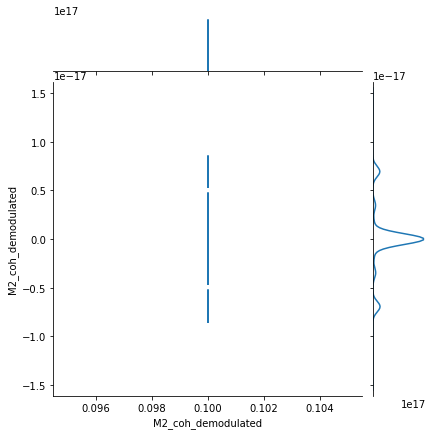

In [23]:
import seaborn as sns
sns.jointplot(x=ds.M2_coh_demodulated.real,y = ds.M2_coh_demodulated.imag,kind='kde')

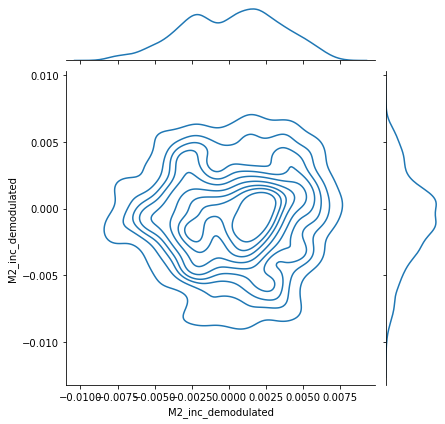

In [24]:
sns.jointplot(x=ds_mean.M2_mix_demodulated.sel(T=5).real,
              y = ds_mean.M2_mix_demodulated.sel(T=5).imag,kind='kde')
sns.jointplot(x=ds_mean.M2_inc_demodulated.sel(T=5).real,
              y = ds_mean.M2_inc_demodulated.sel(T=5).imag,kind='kde')
#sns.jointplot(x=ds.M2_mix_demodulated.sel(T=30).mean('draw').real,
#              y = ds.M2_mix_demodulated.sel(T=30).imag,kind='kde')
#sns.jointplot(x=ds.M2_mix_demodulated.sel(T=80).mean('draw').real,
#              y = ds.M2_mix_demodulated.sel(T=80).imag,kind='kde')

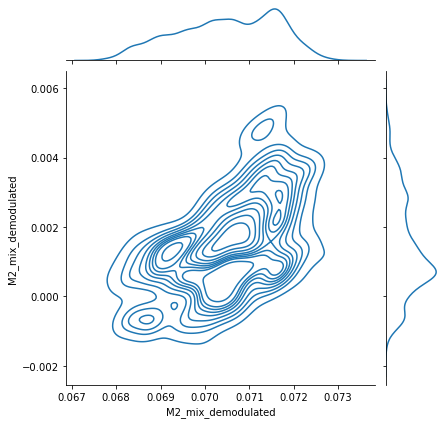

In [25]:
sns.jointplot(x=ds_mean.M2_mix_demodulated.sel(T=80).real,
              y = ds_mean.M2_mix_demodulated.sel(T=80).imag,kind='kde')

sns.jointplot(x=ds_mean.M2_inc_demodulated.sel(T=80).real,
              y = ds_mean.M2_inc_demodulated.sel(T=80).imag,kind='kde')

In [26]:
u_low = hf.low_frequency_signal()
p = dict(U=1.)

low = u_low.generate_tseries(params=p, seed=10,T=T_low,time=(t_size,1/24),draws=nb_draws
                            ).rename('low_signal').persist()
low = low.rename({'T':'T_low'})

In [27]:
ds['low'] = low
ds = ds.persist()

In [28]:
ds['total_coh'] = ds['high_MS_coh']+ds['low']
ds['total_mix'] = ds['high_MS_mix']+ds['low']
ds['total_inc'] = ds['high_MS_inc']+ds['low']
ds = ds.persist()

In [29]:
ds_mean = ds.mean('draw').persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in cdouble_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
import sstats.sigp_AP as sigp_AP
ds_filtered = {}
for c,om in zip(['M2','S2','high_MS','total'],[omega_M2,omega_S2,omega,omega]):
    for p in ['_coh','_mix','_inc']:
        ds_filtered[c+p] = xr.concat([sigp_AP.bpass_demodulate(ds[c+p].real, om, dband, 30)[0] for dband in [0.1,0.2,0.3]],dim='bandwidth'
                              ).assign_coords({'bandwidth':[0.2,0.4,0.6]})

In [33]:
ds_filtered.keys()

dict_keys(['M2_coh', 'M2_mix', 'M2_inc', 'S2_coh', 'S2_mix', 'S2_inc', 'high_MS_coh', 'high_MS_mix', 'high_MS_inc', 'total_coh', 'total_mix', 'total_inc'])

In [40]:
ds_filt = xr.merge([ds_filtered[k].rename({'bpassed':k+'_bpassed','demodulated':k+'_demodulated','exp':k+'_exp'}) for k in ds_filtered.keys()])

In [44]:
sns.jointplot(x = ds['M2_mix_demodulated'].real.mean('draw').sel(T=80),
              y=ds['M2_mix_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

In [47]:
ds_filt_mean = ds_filt.mean('draw').persist()
ds_filt_mean

<xarray.Dataset>
Dimensions:                  (time: 7200, bandwidth: 3, T: 3, T_low: 3)
Coordinates: (12/22)
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
    M2_coh_bpassed           (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_demodulated       (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
  * bandwidth                (bandwidth) float64 0.2 0.4 0.6
  * T                        (T) int64 5 30 80
    ...                       ...
    high_MS_mix_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    high_MS_inc_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
  * T_low                    (T_low) int64 5 15 30
    total_coh_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_mix_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_inc_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
Data variables:
    M2_coh                   (bandwidth, time) float64 0.1 0.08748 ... -0.08032
    M2_mix                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    M2_inc                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    S2_coh                   (bandwidth, time) float64 0.1 0.0866 ... 0.0866
    S2_mix                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    S2_inc                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    high_MS_coh              (bandwidth, time) float64 0.2 0.1741 ... 0.006286
    high_MS_mix              (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    high_MS_inc              (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    total_coh                (bandwidth, time, T_low) float64 dask.array<chunksize=(1, 7200, 3), meta=np.ndarray>
    total_mix                (bandwidth, T, time, T_low) float64 dask.array<chunksize=(1, 3, 7200, 3), meta=np.ndarray>
    total_inc                (bandwidth, T, time, T_low) float64 dask.array<chunksize=(1, 3, 7200, 3), meta=np.ndarray>

In [53]:
ds_filt_mean['M2_coh'].real

<xarray.DataArray 'M2_coh' (bandwidth: 3, time: 7200)>
array([[ 0.1       ,  0.08747542,  0.05303897, ..., -0.09310433,
        -0.09912567, -0.08031687],
       [ 0.1       ,  0.08747542,  0.05303897, ..., -0.09310433,
        -0.09912567, -0.08031687],
       [ 0.1       ,  0.08747542,  0.05303897, ..., -0.09310433,
        -0.09912567, -0.08031687]])
Coordinates:
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
    M2_coh_bpassed           (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_demodulated       (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
  * bandwidth                (bandwidth) float64 0.2 0.4 0.6
    M2_mix_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
    M2_inc_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
    S2_coh_bpassed           (bandwidth, time) complex128 (7.068738878185994e...
    S2_coh_demodulated       (bandwidth, time) complex128 (7.068738878185994e...
    S2_coh_exp               (time) complex128 (1+0j) ... (0.8660254037841576...
    S2_mix_exp               (time) complex128 (1+0j) ... (0.8660254037841576...
    S2_inc_exp               (time) complex128 (1+0j) ... (0.8660254037841576...
    high_MS_coh_bpassed      (bandwidth, time) complex128 (1.5093670905722927...
    high_MS_coh_demodulated  (bandwidth, time) complex128 (1.5093670905722927...
    high_MS_coh_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    high_MS_mix_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    high_MS_inc_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    total_coh_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_mix_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_inc_exp            (time) complex128 (1+0j) ... (0.0572698722072138...

TypeError: illegal primitive data type, must be one of dict_keys(['S1', 'i1', 'u1', 'i2', 'u2', 'i4', 'u4', 'i8', 'u8', 'f4', 'f8']), got complex128

In [54]:
import seaborn as sns
sns.jointplot(x = ds['M2_coh_demodulated'].real,
              y=ds['M2_coh_demodulated'].imag,kind="hex")

sns.jointplot(x = ds['M2_mix_demodulated'].real.mean('draw').sel(T=80),
              y=ds['M2_mix_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds['M2_inc_demodulated'].real.mean('draw').sel(T=80),
              y=ds['M2_inc_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['M2_coh'].demodulated.real.sel(bandwidth=0.4),
              y=ds_filtered['M2_coh'].demodulated.imag.sel(bandwidth=0.4),kind="hex")

sns.jointplot(x = ds_filtered['M2_mix'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['M2_mix'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['M2_inc'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['M2_inc'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2aabbf0631f0> (for post_execute):


KeyboardInterrupt: 

In [76]:
_ds = ds_mean.copy()

for c in ['M2','S2','high_MS']:
    for p in ['_coh','_mix','_inc']:
        _ds[c+p+'_demodulated_real'] = _ds[c+p+'_demodulated'].real
        _ds[c+p+'_demodulated_imag'] = _ds[c+p+'_demodulated'].imag
        _ds[c+p+'_demod_filt_real'] = ds_filtered[c+p].demodulated.real#.mean('draw')
        _ds[c+p+'_demod_filt_imag'] = ds_filtered[c+p].demodulated.imag#.mean('draw')
        _ds = _ds.drop(c+p)
        _ds = _ds.drop(c+p+'_demodulated')
for p in ['_coh','_mix','_inc']:        
    _ds['total'+p+'_demod_filt_real'] = ds_filtered['total'+p].demodulated.real#.mean('draw')
    _ds['total'+p+'_demod_filt_imag'] = ds_filtered['total'+p].demodulated.imag#.mean('draw')
    _ds = _ds.drop('total'+p)


In [79]:
_ds = _ds.drop(['bpassed','demodulated','exp'])

In [80]:
_ds.to_netcdf('/home1/datawork/zcaspar/mit4320/synthetic_mean.nc')

In [68]:
ds_filt_mean

<xarray.Dataset>
Dimensions:                  (time: 7200, bandwidth: 3, T: 3, T_low: 3)
Coordinates: (12/22)
  * time                     (time) float64 0.0 0.04167 0.08333 ... 299.9 300.0
    M2_coh_bpassed           (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_demodulated       (bandwidth, time) complex128 (8.02606988277906e-...
    M2_coh_exp               (time) complex128 (1+0j) ... (-0.803168680159691...
  * bandwidth                (bandwidth) float64 0.2 0.4 0.6
  * T                        (T) int64 5 30 80
    ...                       ...
    high_MS_mix_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
    high_MS_inc_exp          (time) complex128 (1+0j) ... (0.0572698722072138...
  * T_low                    (T_low) int64 5 15 30
    total_coh_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_mix_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
    total_inc_exp            (time) complex128 (1+0j) ... (0.0572698722072138...
Data variables:
    M2_coh                   (bandwidth, time) float64 0.1 0.08748 ... -0.08032
    M2_mix                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    M2_inc                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    S2_coh                   (bandwidth, time) float64 0.1 0.0866 ... 0.0866
    S2_mix                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    S2_inc                   (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    high_MS_coh              (bandwidth, time) float64 0.2 0.1741 ... 0.006286
    high_MS_mix              (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    high_MS_inc              (bandwidth, T, time) float64 dask.array<chunksize=(1, 3, 7200), meta=np.ndarray>
    total_coh                (bandwidth, time, T_low) float64 dask.array<chunksize=(1, 7200, 3), meta=np.ndarray>
    total_mix                (bandwidth, T, time, T_low) float64 dask.array<chunksize=(1, 3, 7200, 3), meta=np.ndarray>
    total_inc                (bandwidth, T, time, T_low) float64 dask.array<chunksize=(1, 3, 7200, 3), meta=np.ndarray>

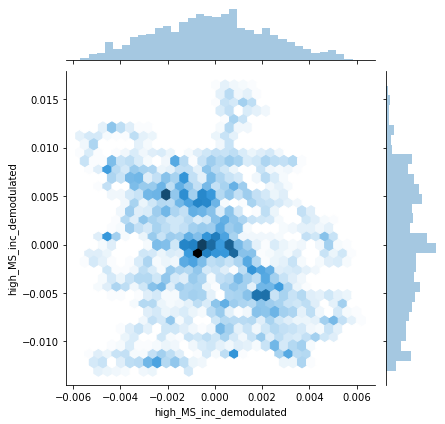

In [34]:
import seaborn as sns
sns.jointplot(x = ds['high_MS_coh_demodulated'].real,
              y=ds['high_MS_coh_demodulated'].imag,kind="hex")

sns.jointplot(x = ds['high_MS_mix_demodulated'].real.mean('draw').sel(T=80),
              y=ds['high_MS_mix_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds['high_MS_inc_demodulated'].real.mean('draw').sel(T=80),
              y=ds['high_MS_inc_demodulated'].imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['high_MS_coh'].demodulated.real.sel(bandwidth=0.4),
              y=ds_filtered['high_MS_coh'].demodulated.imag.sel(bandwidth=0.4),kind="hex")

sns.jointplot(x = ds_filtered['high_MS_mix'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['high_MS_mix'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

sns.jointplot(x = ds_filtered['high_MS_inc'].demodulated.real.mean('draw').sel(T=80),
              y=ds_filtered['high_MS_inc'].demodulated.imag.mean('draw').sel(T=80),kind="hex")

In [54]:
h_M2 = signal.hilbert(ds['M2_coh'].real)

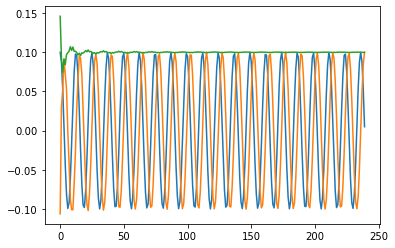

In [65]:
plt.plot(h_M2.real[0:int(10/dt)])
plt.plot(h_M2.imag[0:int(10/dt)])
plt.plot(np.abs(h_M2[0:int(10/dt)]))

In [74]:
h_M2_demod = h_M2*np.exp(-1j*rad*omega_M2*ds.time)

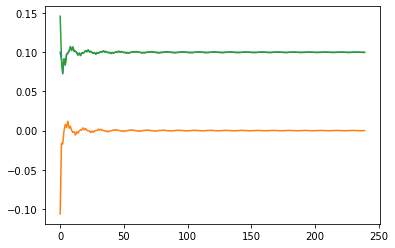

In [75]:
plt.plot(h_M2_demod.real[0:int(10/dt)])
plt.plot(h_M2_demod.imag[0:int(10/dt)])
plt.plot(np.abs(h_M2_demod[0:int(10/dt)]))

In [76]:
plt.scatter(np.real(h_M2_demod),np.imag(h_M2_demod))

AttributeError: 'JointGrid' object has no attribute 'figure'

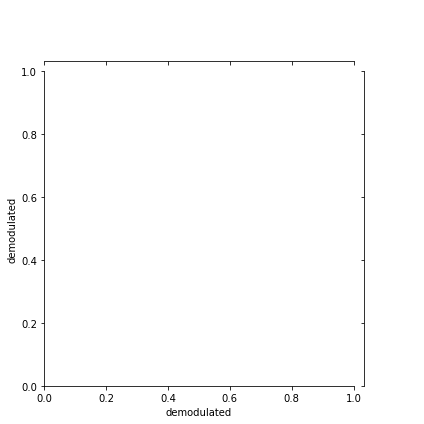

In [32]:


g = sns.JointGrid(x=ds_filtered['M2_coh'].demodulated.real.sel(bandwidth=0.4),
                  y=ds_filtered['M2_coh'].demodulated.real.sel(bandwidth=0.4))

# Create an inset legend for the histogram colorbar
cax = g.figure.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, discrete=(True, False),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

(array([4.0000e+00, 5.0000e+00, 4.6000e+01, 1.1916e+04, 1.6000e+01,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.88176461, 0.91739051, 0.9530164 , 0.9886423 , 1.02426819,
        1.05989408, 1.09551998, 1.13114587, 1.16677177, 1.20239766,
        1.23802356]),
 <BarContainer object of 10 artists>)

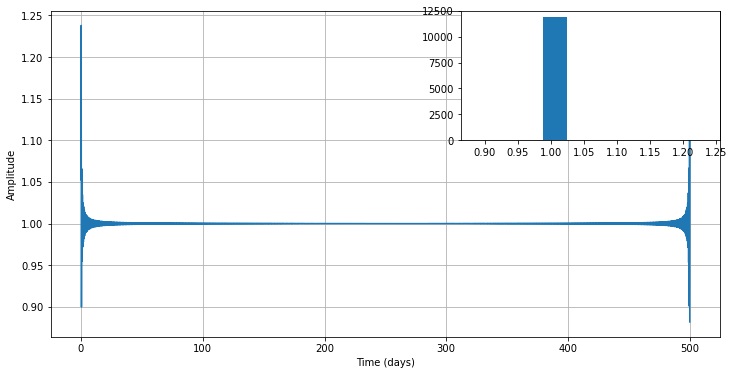

In [30]:
s = np.abs((ds.M2_coh_demodulated)**2).mean('draw')
fig = plt.figure(figsize=(12,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.high_MS_coh_demodulated)**2).mean('draw')
fig = plt.figure(figsize=(12,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

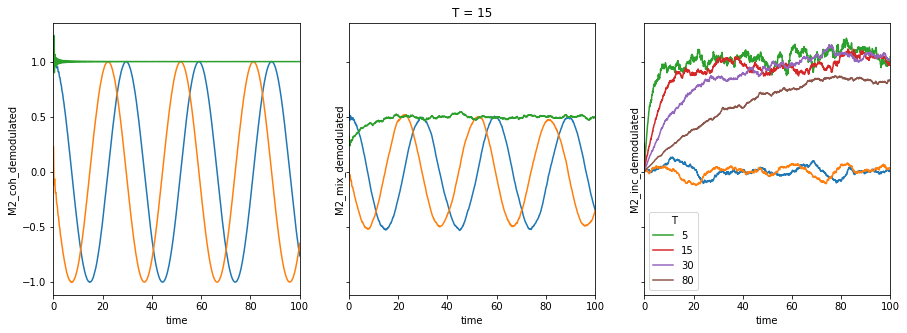

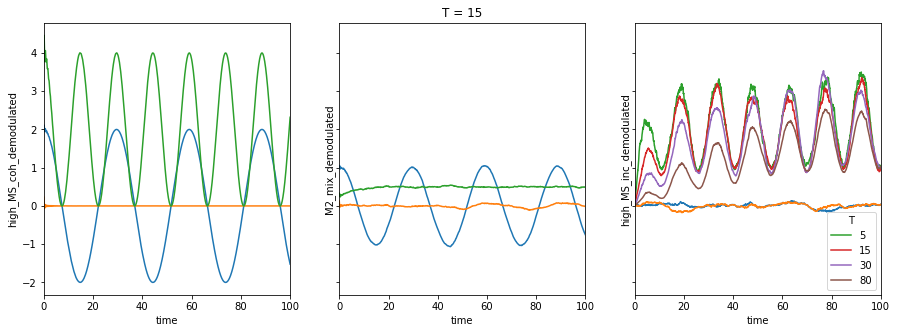

In [38]:
delta_T = 100
fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.M2_coh_demodulated.real.mean('draw').plot(ax=axs[0],xlim=(0,delta_T))
ds.M2_coh_demodulated.imag.mean('draw').plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.M2_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.M2_mix_demodulated.real.mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
ds.M2_mix_demodulated.imag.mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.M2_mix_demodulated)**2).mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))

ds.M2_inc_demodulated.real.mean('draw').sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
ds.M2_inc_demodulated.imag.mean('draw').sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.M2_inc_demodulated)**2).mean('draw').plot(ax=axs[2],xlim=(0,delta_T),hue='T')

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.M2_mix_demodulated)**2).mean('draw').sel(T=15).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=15).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').plot(ax=axs[2],xlim=(0,delta_T),hue='T')

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.high_MS_mix_demodulated)**2).mean('draw').sel(T=30).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').sel(T=30).plot(ax=axs[2],xlim=(0,delta_T))

fig,axs = plt.subplots(1,3,figsize=(15,5),sharey=True)
ds.high_MS_coh_demodulated.mean('draw').real.plot(ax=axs[0],xlim=(0,delta_T))
ds.high_MS_coh_demodulated.mean('draw').imag.plot(ax=axs[0],xlim=(0,delta_T))
(np.abs(ds.high_MS_coh_demodulated)**2).mean('draw').plot(ax=axs[0],xlim=(0,delta_T))

ds.high_MS_mix_demodulated.mean('draw').real.sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))
ds.high_MS_mix_demodulated.mean('draw').imag.sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))
(np.abs(ds.high_MS_mix_demodulated)**2).mean('draw').sel(T=80).plot(ax=axs[1],xlim=(0,delta_T))

ds.high_MS_inc_demodulated.mean('draw').real.sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))
ds.high_MS_inc_demodulated.mean('draw').imag.sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))
(np.abs(ds.high_MS_inc_demodulated)**2).mean('draw').sel(T=80).plot(ax=axs[2],xlim=(0,delta_T))

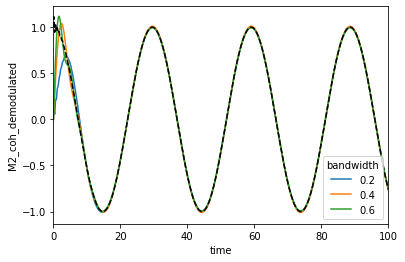

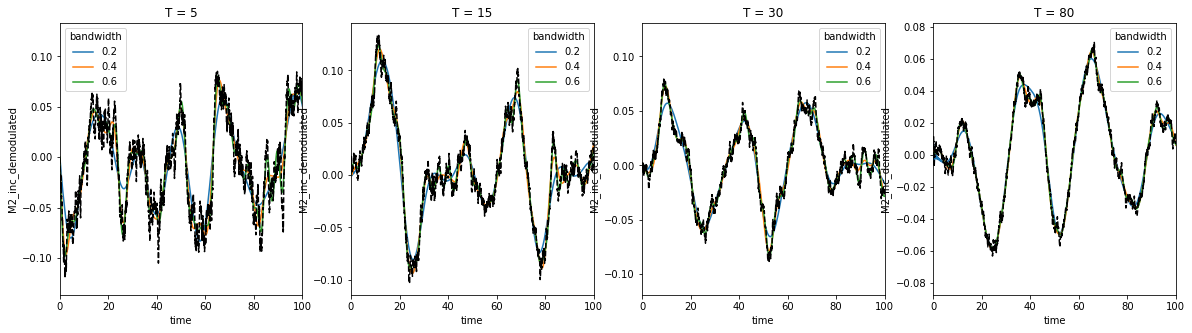

In [39]:
ds_filtered['M2_coh'].demodulated.mean('draw').real.plot(xlim=(0,delta_T),hue='bandwidth')
ds.M2_coh_demodulated.mean('draw').real.plot(c='k',linestyle='--',xlim=(0,delta_T))
fig,axs = plt.subplots(1,ds.T.size,figsize=(5*ds.T.size,5))
for ax ,t in zip(axs,ds.T):
    ds_filtered['M2_mix'].demodulated.mean('draw').real.sel(T=t).plot(ax=ax,xlim=(0,delta_T),hue='bandwidth')
    ds.M2_mix_demodulated.mean('draw').real.sel(T=t).plot(ax=ax,c='k',linestyle='--',xlim=(0,delta_T))

fig,axs = plt.subplots(1,ds.T.size,figsize=(5*ds.T.size,5))
for ax ,t in zip(axs,ds.T):
    ds_filtered['M2_inc'].demodulated.mean('draw').real.sel(T=t).plot(ax=ax,xlim=(0,delta_T),hue='bandwidth')
    ds.M2_inc_demodulated.mean('draw').real.sel(T=t).plot(ax=ax,c='k',linestyle='--',xlim=(0,delta_T))

In [93]:
ds_filtered['M2_coh'].demodulated.real.mean('draw')

<xarray.DataArray 'demodulated' (bandwidth: 3, time: 12000)>
array([[ 7.54683545e-10,  9.43415838e-02,  1.28612472e-01, ...,
         9.88973021e-02,  5.79307074e-02, -1.99162802e-02],
       [ 3.09159729e-09,  6.47760742e-02,  9.87018960e-02, ...,
         8.10057289e-02,  3.69714191e-02, -1.61597619e-02],
       [ 7.08552519e-09,  5.83595948e-02,  1.00107718e-01, ...,
         8.63857223e-02,  3.38337468e-02, -1.44799908e-02]])
Coordinates:
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 499.9 499.9 500.0
    exp        (time) complex128 (1+0j) ... (0.9963946710000068+0.08483902169...
  * bandwidth  (bandwidth) float64 0.2 0.4 0.6

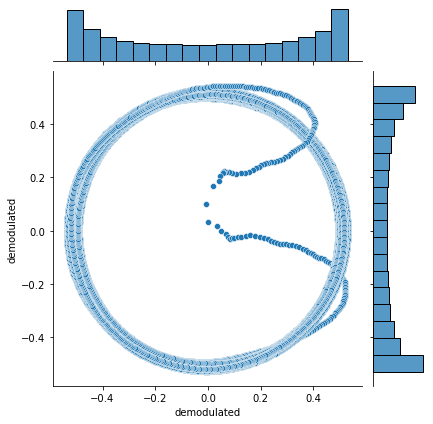

In [97]:
import seaborn as sns
sns.jointplot(x = ds_filtered['M2_coh'].demodulated.real.mean('draw').sel(bandwidth=0.4),y=ds_filtered['M2_coh'].demodulated.imag.mean('draw').sel(bandwidth=0.4),kind="scatter")

sns.jointplot(x = ds_filtered['M2_mix'].demodulated.real.mean('draw').sel(bandwidth=0.4,T=80),y=ds_filtered['M2_mix'].demodulated.imag.mean('draw').sel(bandwidth=0.4,T=80),kind="scatter")

sns.jointplot(x = ds_filtered['M2_inc'].demodulated.real.mean('draw').sel(bandwidth=0.4,T=80),y=ds_filtered['M2_inc'].demodulated.imag.mean('draw').sel(bandwidth=0.4,T=80),kind="scatter")

(array([4.0000e+00, 5.0000e+00, 4.6000e+01, 1.1916e+04, 1.6000e+01,
        4.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([0.88176461, 0.91739051, 0.9530164 , 0.9886423 , 1.02426819,
        1.05989408, 1.09551998, 1.13114587, 1.16677177, 1.20239766,
        1.23802356]),
 <BarContainer object of 10 artists>)

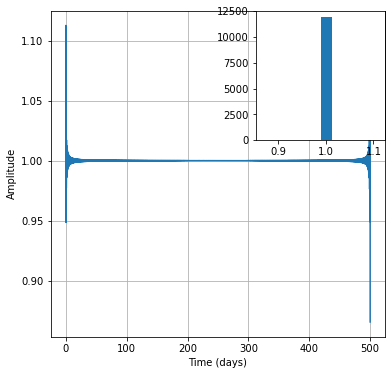

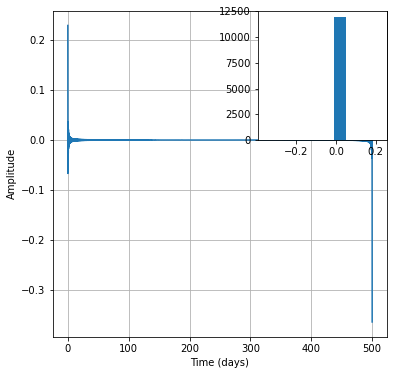

In [95]:
s = ds.M2_coh_demodulated.real.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = ds.M2_coh_demodulated.imag.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.M2_coh_demodulated)**2).mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

(array([2611., 1164.,  956.,  879.,  858.,  881.,  961., 1156., 2525.,
           9.]),
 array([5.57766610e-08, 4.46081224e-01, 8.92162392e-01, 1.33824356e+00,
        1.78432473e+00, 2.23040590e+00, 2.67648706e+00, 3.12256823e+00,
        3.56864940e+00, 4.01473057e+00, 4.46081174e+00]),
 <BarContainer object of 10 artists>)

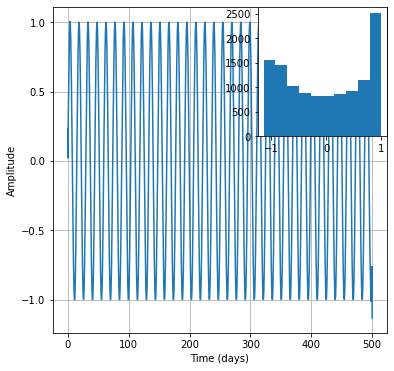

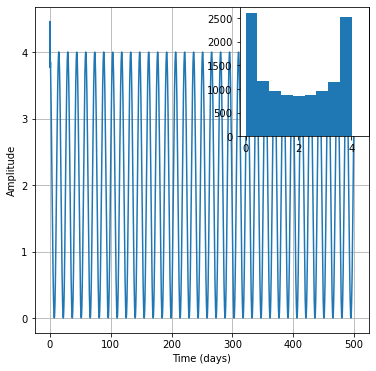

In [96]:
s = ds.high_MS_coh_demodulated.real.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = ds.high_MS_coh_demodulated.imag.mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

s = np.abs((ds.high_MS_coh_demodulated)**2).mean('draw')
plt.figure(figsize=(6,6))
plt.plot(ds.time,s)
plt.ylabel('Amplitude');plt.xlabel('Time (days)')
plt.grid()
a = plt.axes([.6, .58, .3, .3])
plt.hist(s)

In [60]:
cluster.close()